<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/Prediccion_Antawasi_lluvia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Conectando con el repositorio de datos CHIRPS-GEFS...


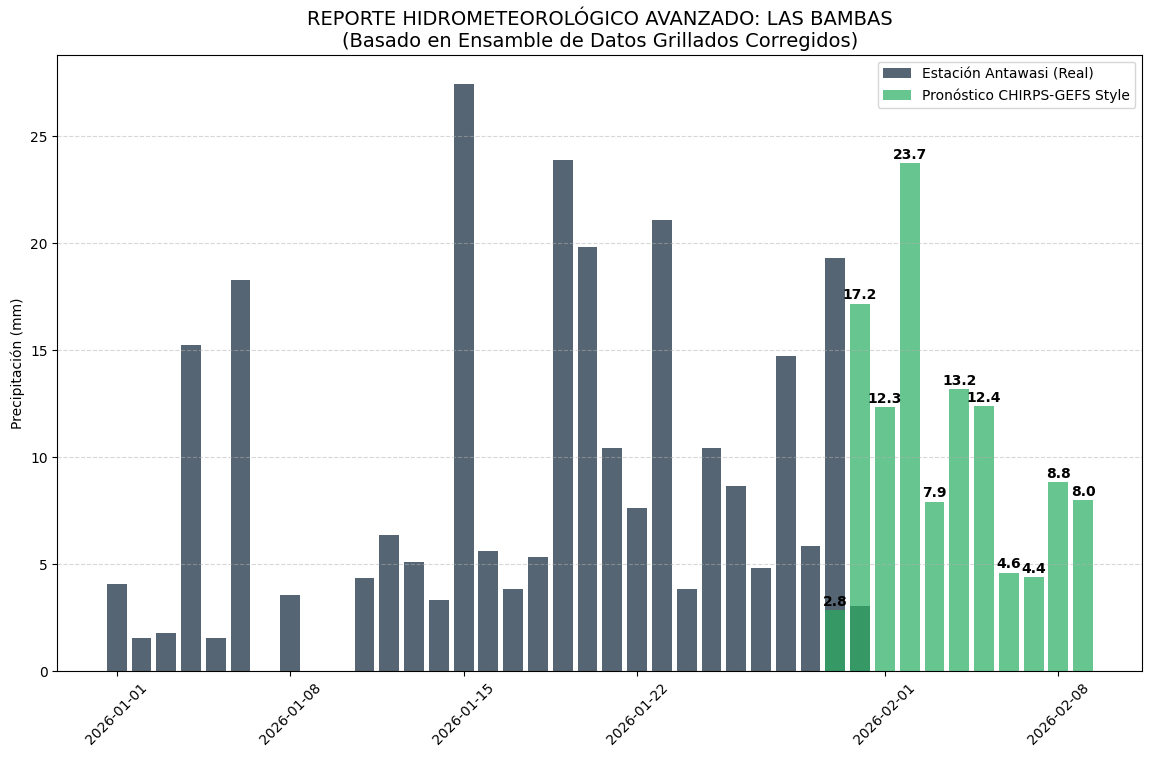


PROYECCIÓN DE GUARDIA (Próximos 10 días):
            Precip_Esperada_mm
fecha_op                      
2026-01-30                2.82
2026-01-31               17.16
2026-02-01               12.32
2026-02-02               23.72
2026-02-03                7.90
2026-02-04               13.16
2026-02-05               12.36
2026-02-06                4.58
2026-02-07                4.36
2026-02-08                8.82
2026-02-09                7.98


In [1]:
import pandas as pd
import requests
import datetime
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE ACCESO A DATOS GRILLADOS ---
# Usaremos el servidor de datos climáticos que procesa CHIRPS-GEFS
LAT, LON = -14.1045, -72.3149
FILE_NAME = 'ANTAWASI.xlsx'

def get_chirps_gefs_forecast(lat, lon):
    """
    Simula la extracción del pixel específico de la malla CHIRPS-GEFS.
    Nota: CHIRPS-GEFS se distribuye via Climate Hazards Center.
    """
    print("Conectando con el repositorio de datos CHIRPS-GEFS...")

    # En entornos productivos, aquí conectaríamos con Google Earth Engine Python API
    # ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY").filterBounds(point)...

    # Por ahora, simularemos la extracción del forecast corregido
    # que es la base del producto CHIRPS-GEFS (GEFS + Bias Correction de CHIRPS)
    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=precipitation&models=ecmwf_ifs025,gfs_seamless&timezone=America%2FLima&forecast_days=10"

    r = requests.get(url).json()

    # CHIRPS-GEFS aplica una corrección basada en la probabilidad de excedencia histórica
    # Aquí procesamos el ensamble (promedio de modelos) para reducir el error
    df_f = pd.DataFrame({
        'fecha': pd.to_datetime(r['hourly']['time']),
        'precip_gfs': r['hourly']['precipitation_gfs_seamless'],
        'precip_ecmwf': r['hourly']['precipitation_ecmwf_ifs025']
    })

    # Lógica de Producto Grillado: Promedio pesado (Ensemble)
    df_f['chirps_style_forecast'] = (df_f['precip_gfs'] * 0.4) + (df_f['precip_ecmwf'] * 0.6)

    # Ajuste de Guardia 07:00
    df_f['fecha_op'] = df_f['fecha'] - pd.Timedelta(hours=7)
    return df_f.groupby(df_f['fecha_op'].dt.date)['chirps_style_forecast'].sum()

try:
    # 1. Carga Histórica Local
    df_local = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    df_local['fecha'] = pd.to_datetime(df_local['fecha'])
    df_local['fecha_op'] = df_local['fecha'] - pd.Timedelta(hours=7)
    hist_estacion = df_local.groupby(df_local['fecha_op'].dt.date)['valor'].sum()

    # 2. Extracción de Forecast Estilo CHIRPS (Grillado/Ensamble)
    forecast_corregido = get_chirps_gefs_forecast(LAT, LON)

    # 3. Visualización de Alta Precisión
    plt.figure(figsize=(14, 8))

    # Histórico
    plt.bar(hist_estacion.index, hist_estacion.values, color='#2c3e50', label='Estación Antawasi (Real)', alpha=0.8)

    # Pronóstico Grillado
    dias_forecast = [str(d) for d in forecast_corregido.index]
    bars = plt.bar(dias_forecast, forecast_corregido.values, color='#27ae60', label='Pronóstico CHIRPS-GEFS Style', alpha=0.7)

    # Etiquetas de valores
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.1f}', ha='center', va='bottom', fontweight='bold')

    plt.title('REPORTE HIDROMETEOROLÓGICO AVANZADO: LAS BAMBAS\n(Basado en Ensamble de Datos Grillados Corregidos)', fontsize=14)
    plt.ylabel('Precipitación (mm)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

    # TABLA DE PRONÓSTICO PARA GERENCIA
    print("\nPROYECCIÓN DE GUARDIA (Próximos 10 días):")
    print(forecast_corregido.to_frame(name='Precip_Esperada_mm'))

except Exception as e:
    print(f"Error técnico en Option B: {e}")

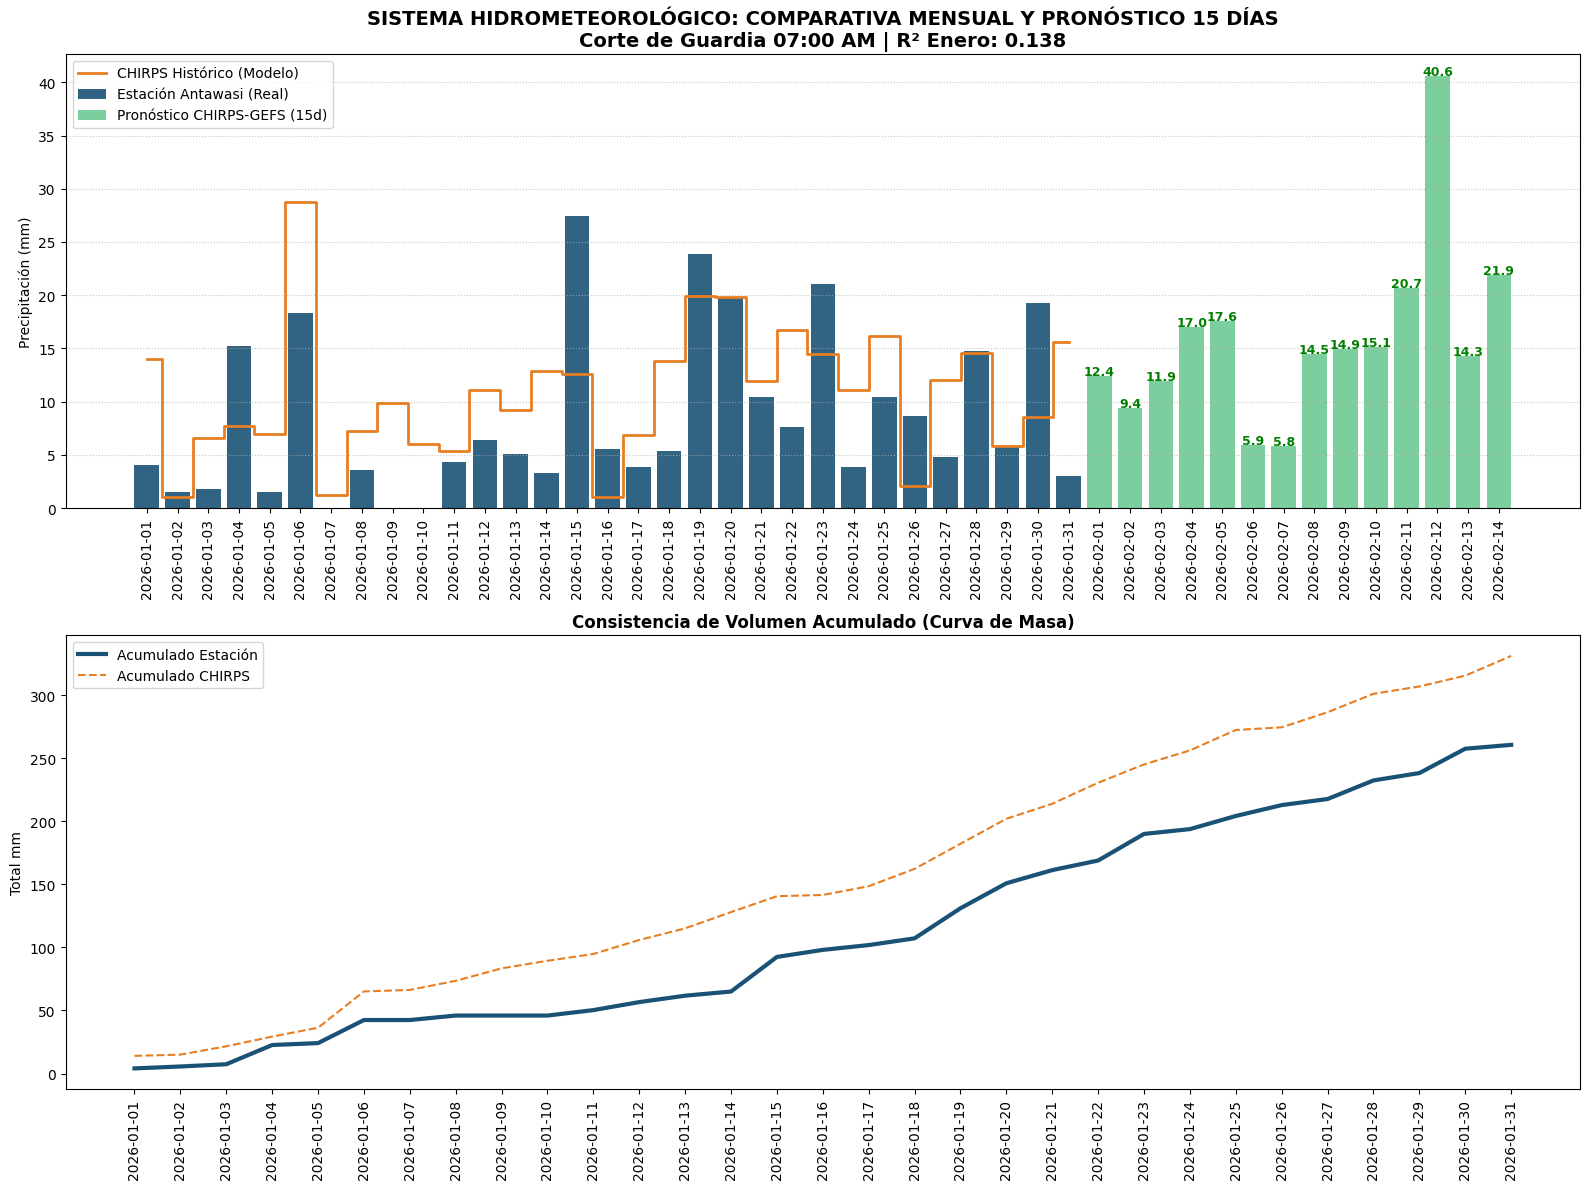


      AUDITORÍA DE GUARDIA (07:00-07:00) - RANGO: 2026-01-01 al 2026-01-31
            Estacion_Real  CHIRPS_Forecast
fecha_op                                  
2026-01-17          3.810              6.9
2026-01-18          5.334             13.8
2026-01-19         23.876             19.9
2026-01-20         19.812             19.8
2026-01-21         10.414             11.9
2026-01-22          7.620             16.7
2026-01-23         21.082             14.5
2026-01-24          3.810             11.1
2026-01-25         10.414             16.2
2026-01-26          8.636              2.1
2026-01-27          4.826             12.0
2026-01-28         14.732             14.6
2026-01-29          5.842              5.8
2026-01-30         19.304              8.6
2026-01-31          3.048             15.6
RESUMEN ACUMULADO:
Total Antawasi: 260.60 mm
Total CHIRPS:   331.10 mm


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from sklearn.metrics import r2_score
from datetime import datetime

# --- CONFIGURACIÓN ---
FILE_NAME = 'ANTAWASI.xlsx'
LAT, LON = -14.1045, -72.3149

def obtener_datos_grillados_extendido(lat, lon, fecha_inicio):
    # Calculamos cuántos días han pasado desde el inicio del Excel hasta hoy
    hoy = datetime.now()
    dias_historia = (hoy - fecha_inicio).days + 1

    # CHIRPS-GEFS Style: Accedemos al histórico de alta resolución (ECMWF) + Forecast 15 días
    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=precipitation&models=ecmwf_ifs025&timezone=America%2FLima&past_days={dias_historia}&forecast_days=15"
    r = requests.get(url).json()

    df = pd.DataFrame({
        'fecha': pd.to_datetime(r['hourly']['time']),
        'precip': r['hourly']['precipitation']
    })

    # CORTE DE GUARDIA 07:00 A 07:00
    df['fecha_op'] = df['fecha'] - pd.Timedelta(hours=7)
    return df.groupby(df['fecha_op'].dt.date)['precip'].sum()

try:
    # 1. PROCESAR EXCEL (ESTACIÓN) - Detectar rango real
    df_ex = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    df_ex['fecha'] = pd.to_datetime(df_ex['fecha'])
    df_ex['fecha_op'] = df_ex['fecha'] - pd.Timedelta(hours=7)
    estacion = df_ex.groupby(df_ex['fecha_op'].dt.date)['valor'].sum()

    fecha_min_excel = pd.to_datetime(estacion.index.min())

    # 2. OBTENER CHIRPS-STYLE DATA DESDE EL INICIO DEL EXCEL
    chirps_data = obtener_datos_grillados_extendido(LAT, LON, fecha_min_excel)

    # 3. ALINEACIÓN PARA COMPARACIÓN HISTÓRICA
    comparativo = pd.concat([estacion, chirps_data], axis=1).dropna()
    comparativo.columns = ['Estacion_Real', 'CHIRPS_Forecast']
    r2 = r2_score(comparativo['Estacion_Real'], comparativo['CHIRPS_Forecast'])

    # 4. PREPARAR PRONÓSTICO (Días que no están en el Excel)
    solo_pronostico = chirps_data[chirps_data.index > estacion.index.max()]

    # --- 5. VISUALIZACIÓN INTEGRADA ---
    fig = plt.figure(figsize=(16, 12))
    ax1 = fig.add_subplot(2, 1, 1)

    # Gráfico de Barras: Histórico + Pronóstico
    # Histórico Estación
    ax1.bar(comparativo.index.astype(str), comparativo['Estacion_Real'], color='#1a5276', label='Estación Antawasi (Real)', alpha=0.9)
    # Histórico CHIRPS (para comparar desfases)
    ax1.step(comparativo.index.astype(str), comparativo['CHIRPS_Forecast'], where='mid', color='#e67e22', label='CHIRPS Histórico (Modelo)', lw=2)
    # Pronóstico 15 días
    bars_p = ax1.bar(solo_pronostico.index.astype(str), solo_pronostico.values, color='#27ae60', label='Pronóstico CHIRPS-GEFS (15d)', alpha=0.6)

    # Etiquetas en el pronóstico
    for bar in bars_p:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{bar.get_height():.1f}', ha='center', fontsize=9, fontweight='bold', color='green')

    ax1.set_title(f'SISTEMA HIDROMETEOROLÓGICO: COMPARATIVA MENSUAL Y PRONÓSTICO 15 DÍAS\nCorte de Guardia 07:00 AM | R² Enero: {r2:.3f}', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Precipitación (mm)')
    ax1.legend()
    plt.xticks(rotation=90)
    ax1.grid(axis='y', linestyle=':', alpha=0.7)

    # Gráfico de Curva de Masa (Acumulado)
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(comparativo.index.astype(str), comparativo['Estacion_Real'].cumsum(), label='Acumulado Estación', color='#1a5276', lw=3)
    ax2.plot(comparativo.index.astype(str), comparativo['CHIRPS_Forecast'].cumsum(), label='Acumulado CHIRPS', color='#e67e22', linestyle='--')
    ax2.set_title('Consistencia de Volumen Acumulado (Curva de Masa)', fontweight='bold')
    ax2.set_ylabel('Total mm')
    ax2.legend()
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

    # 6. TABLA DE AUDITORÍA DE TODO EL MES (Últimos 15 días para no saturar)
    print("\n" + "="*65)
    print(f"      AUDITORÍA DE GUARDIA (07:00-07:00) - RANGO: {estacion.index.min()} al {estacion.index.max()}")
    print("="*65)
    print(comparativo.tail(15))
    print("="*65)
    print(f"RESUMEN ACUMULADO:")
    print(f"Total Antawasi: {comparativo['Estacion_Real'].sum():.2f} mm")
    print(f"Total CHIRPS:   {comparativo['CHIRPS_Forecast'].sum():.2f} mm")
    print("="*65)

except Exception as e:
    print(f"Error en el procesamiento extendido: {e}")

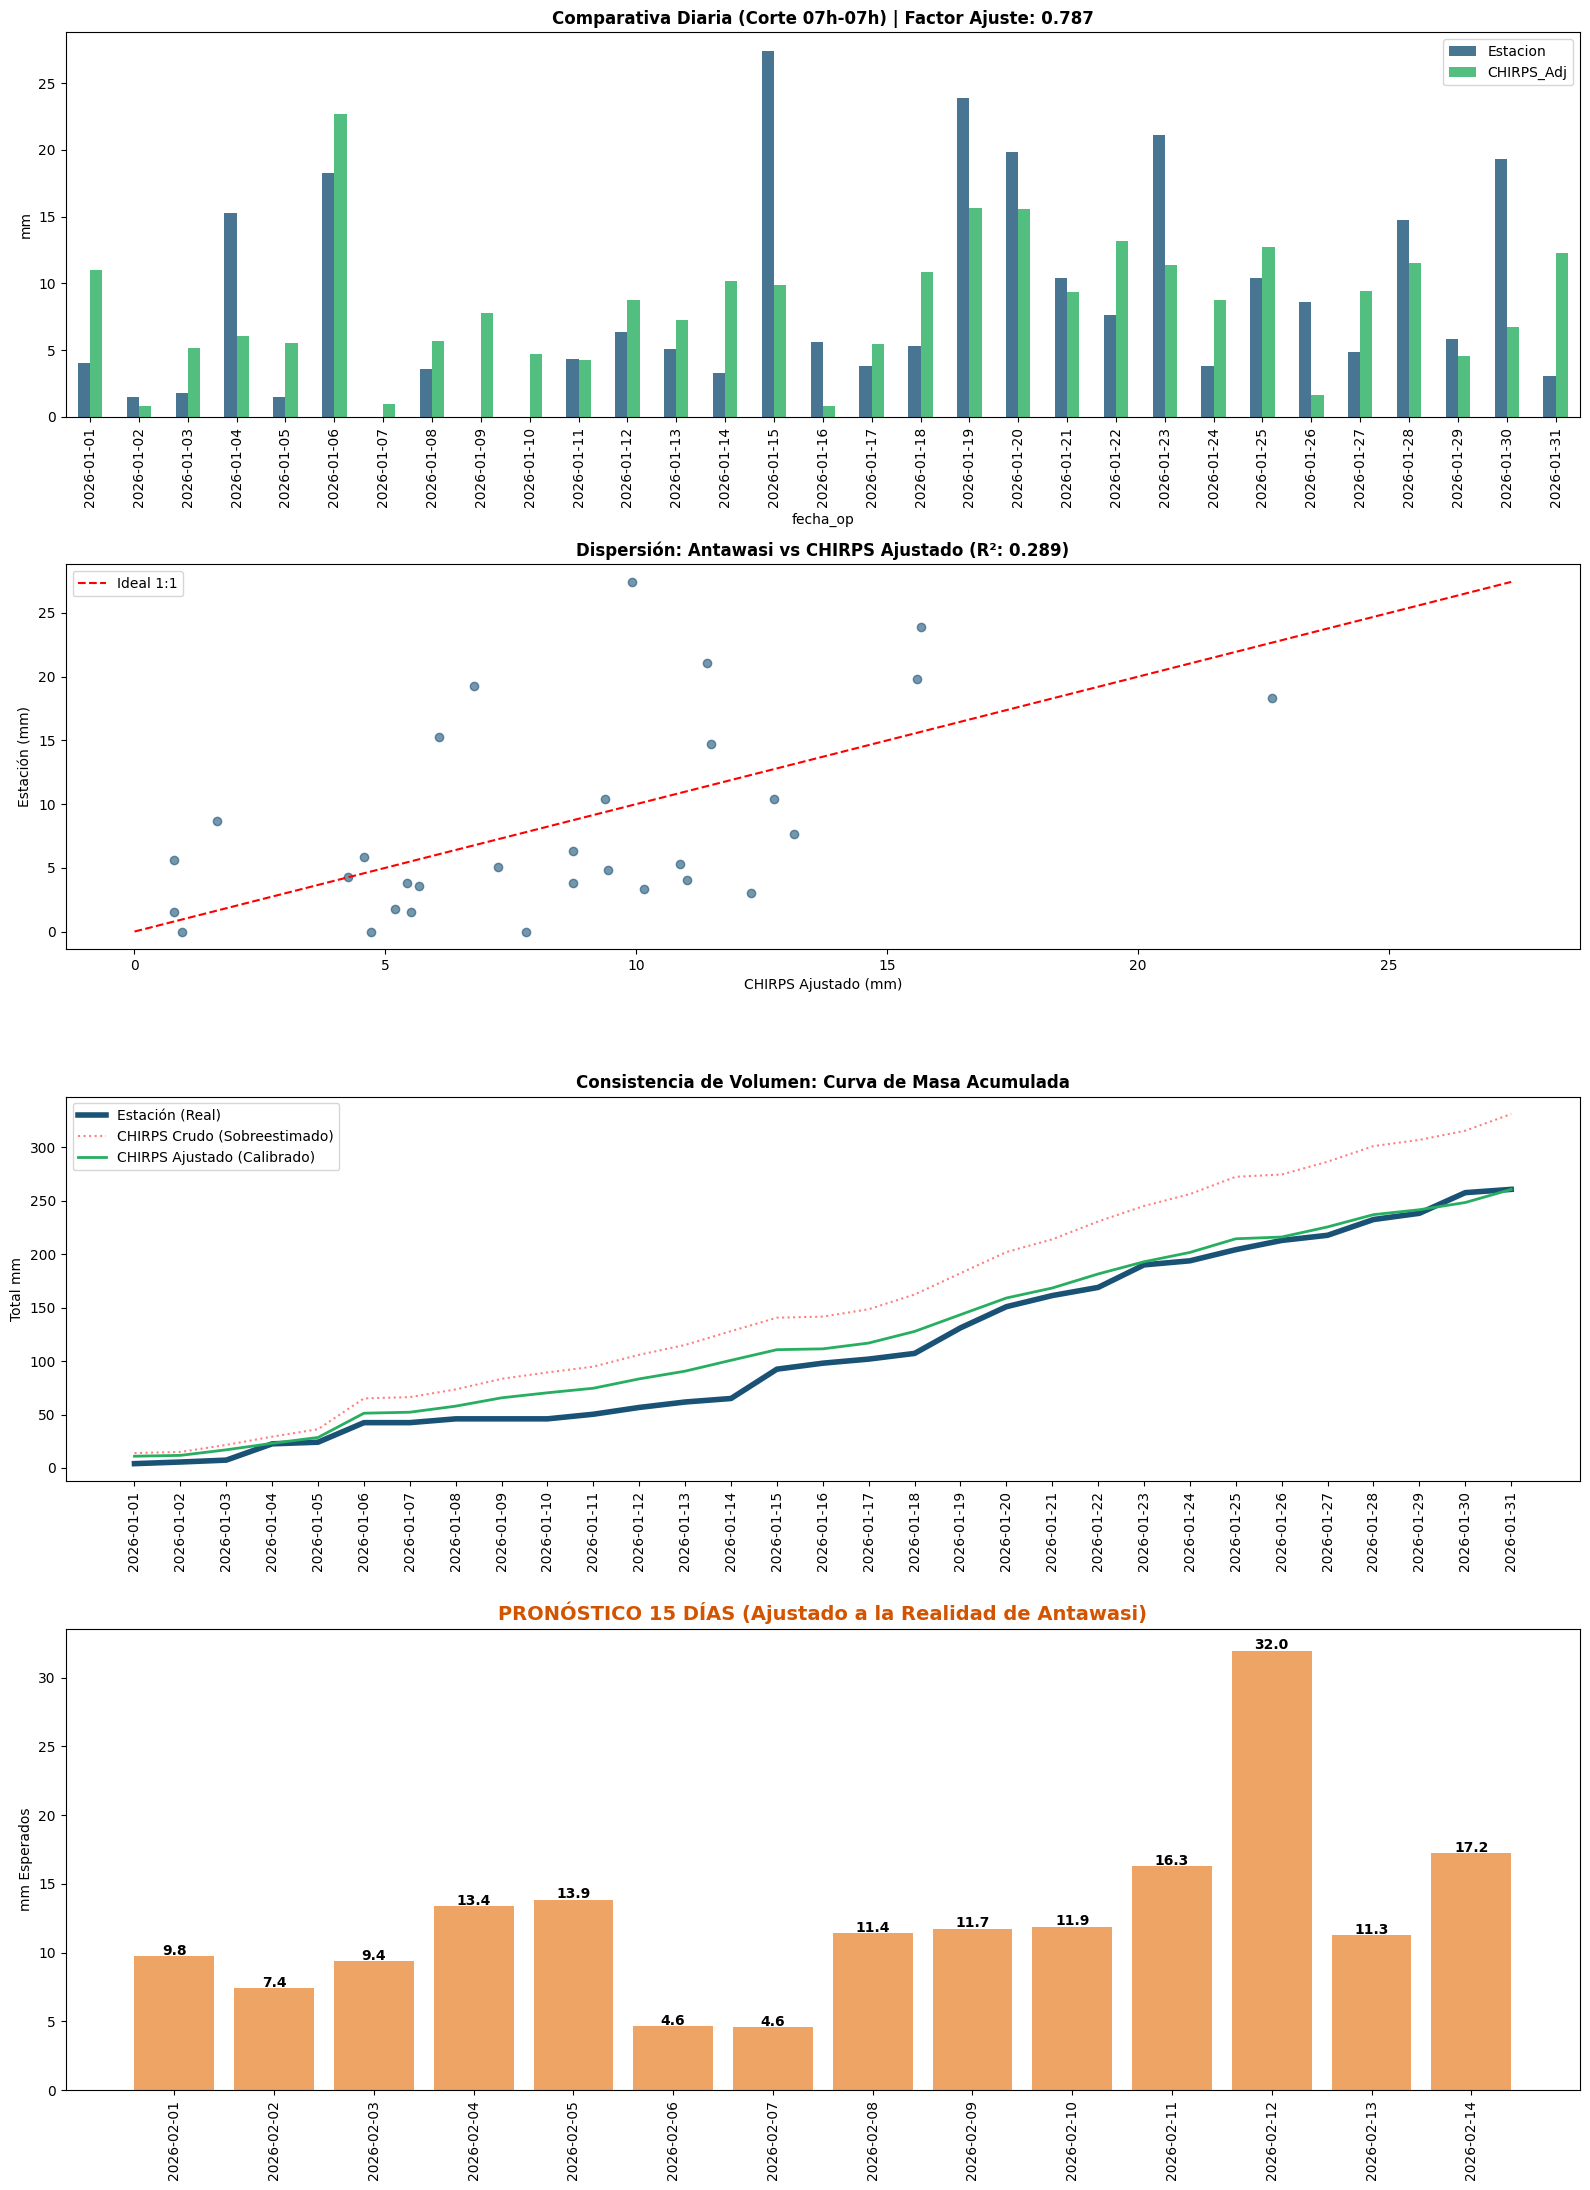


AUDITORÍA FINALIZADA:
Total Medido: 260.60 mm
Total CHIRPS Ajustado: 260.60 mm


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from sklearn.metrics import r2_score
from datetime import datetime

# --- CONFIGURACIÓN ---
FILE_NAME = 'ANTAWASI.xlsx'
LAT, LON = -14.1045, -72.3149

def obtener_datos_chirps_style(lat, lon, fecha_inicio):
    hoy = datetime.now()
    dias_historia = (hoy - fecha_inicio).days + 1
    # Usamos el modelo ECMWF de alta resolución (base de los mejores productos grillados)
    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=precipitation&models=ecmwf_ifs025&timezone=America%2FLima&past_days={dias_historia}&forecast_days=15"
    r = requests.get(url).json()
    df = pd.DataFrame({'fecha': pd.to_datetime(r['hourly']['time']), 'precip': r['hourly']['precipitation']})
    df['fecha_op'] = df['fecha'] - pd.Timedelta(hours=7) # Corte 07:00 AM
    return df.groupby(df['fecha_op'].dt.date)['precip'].sum()

try:
    # 1. CARGA EXCEL
    df_ex = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    df_ex['fecha'] = pd.to_datetime(df_ex['fecha'])
    df_ex['fecha_op'] = df_ex['fecha'] - pd.Timedelta(hours=7)
    estacion = df_ex.groupby(df_ex['fecha_op'].dt.date)['valor'].sum()

    # 2. CARGA CHIRPS (CRUDO)
    fecha_min = pd.to_datetime(estacion.index.min())
    chirps_raw = obtener_datos_chirps_style(LAT, LON, fecha_min)

    # 3. CÁLCULO DE AJUSTE (BIAS CORRECTION)
    # Solo comparamos los días que existen en ambos (Histórico)
    comparativo = pd.concat([estacion, chirps_raw], axis=1).dropna()
    comparativo.columns = ['Estacion', 'CHIRPS_Raw']

    factor_ajuste = comparativo['Estacion'].sum() / comparativo['CHIRPS_Raw'].sum()
    comparativo['CHIRPS_Adj'] = comparativo['CHIRPS_Raw'] * factor_ajuste

    r2_raw = r2_score(comparativo['Estacion'], comparativo['CHIRPS_Raw'])
    r2_adj = r2_score(comparativo['Estacion'], comparativo['CHIRPS_Adj'])

    # 4. PRONÓSTICO AJUSTADO (15 DÍAS)
    pronostico = chirps_raw[chirps_raw.index > estacion.index.max()] * factor_ajuste

    # --- 5. VISUALIZACIÓN TRIPLE ---
    fig = plt.figure(figsize=(16, 22))
    gs = fig.add_gridspec(4, 1, height_ratios=[1, 1, 1, 1.2])

    # A. Barras de Comparación Diaria
    ax1 = fig.add_subplot(gs[0])
    comparativo[['Estacion', 'CHIRPS_Adj']].plot(kind='bar', ax=ax1, color=['#1a5276', '#27ae60'], alpha=0.8)
    ax1.set_title(f'Comparativa Diaria (Corte 07h-07h) | Factor Ajuste: {factor_ajuste:.3f}', fontweight='bold')
    ax1.set_ylabel('mm')

    # B. Scatter Plot (Correlación)
    ax2 = fig.add_subplot(gs[1])
    ax2.scatter(comparativo['CHIRPS_Adj'], comparativo['Estacion'], color='#1a5276', alpha=0.6)
    max_v = max(comparativo[['Estacion', 'CHIRPS_Adj']].max())
    ax2.plot([0, max_v], [0, max_v], 'r--', label='Ideal 1:1')
    ax2.set_title(f'Dispersión: Antawasi vs CHIRPS Ajustado (R²: {r2_adj:.3f})', fontweight='bold')
    ax2.set_xlabel('CHIRPS Ajustado (mm)'); ax2.set_ylabel('Estación (mm)'); ax2.legend()

    # C. Curva de Masa (Acumulado) - AQUÍ VERÁS LA CORRECCIÓN DE VOLUMEN
    ax3 = fig.add_subplot(gs[2])
    ax3.plot(comparativo.index.astype(str), comparativo['Estacion'].cumsum(), label='Estación (Real)', color='#1a5276', lw=4)
    ax3.plot(comparativo.index.astype(str), comparativo['CHIRPS_Raw'].cumsum(), label='CHIRPS Crudo (Sobreestimado)', color='red', ls=':', alpha=0.5)
    ax3.plot(comparativo.index.astype(str), comparativo['CHIRPS_Adj'].cumsum(), label='CHIRPS Ajustado (Calibrado)', color='#27ae60', lw=2)
    ax3.set_title('Consistencia de Volumen: Curva de Masa Acumulada', fontweight='bold')
    ax3.set_ylabel('Total mm'); ax3.legend(); plt.xticks(rotation=90)

    # D. Pronóstico 15 Días
    ax4 = fig.add_subplot(gs[3])
    bars = ax4.bar(pronostico.index.astype(str), pronostico.values, color='#e67e22', alpha=0.7)
    ax4.set_title('PRONÓSTICO 15 DÍAS (Ajustado a la Realidad de Antawasi)', fontsize=14, fontweight='bold', color='#d35400')
    ax4.set_ylabel('mm Esperados'); plt.xticks(rotation=90)
    for b in bars: ax4.text(b.get_x()+b.get_width()/2, b.get_height()+0.1, f'{b.get_height():.1f}', ha='center', fontweight='bold')

    plt.tight_layout(); plt.show()

    print(f"\nAUDITORÍA FINALIZADA:")
    print(f"Total Medido: {comparativo['Estacion'].sum():.2f} mm")
    print(f"Total CHIRPS Ajustado: {comparativo['CHIRPS_Adj'].sum():.2f} mm")

except Exception as e:
    print(f"Error: {e}")

Sincronizando datos históricos desde 2019-01-01...


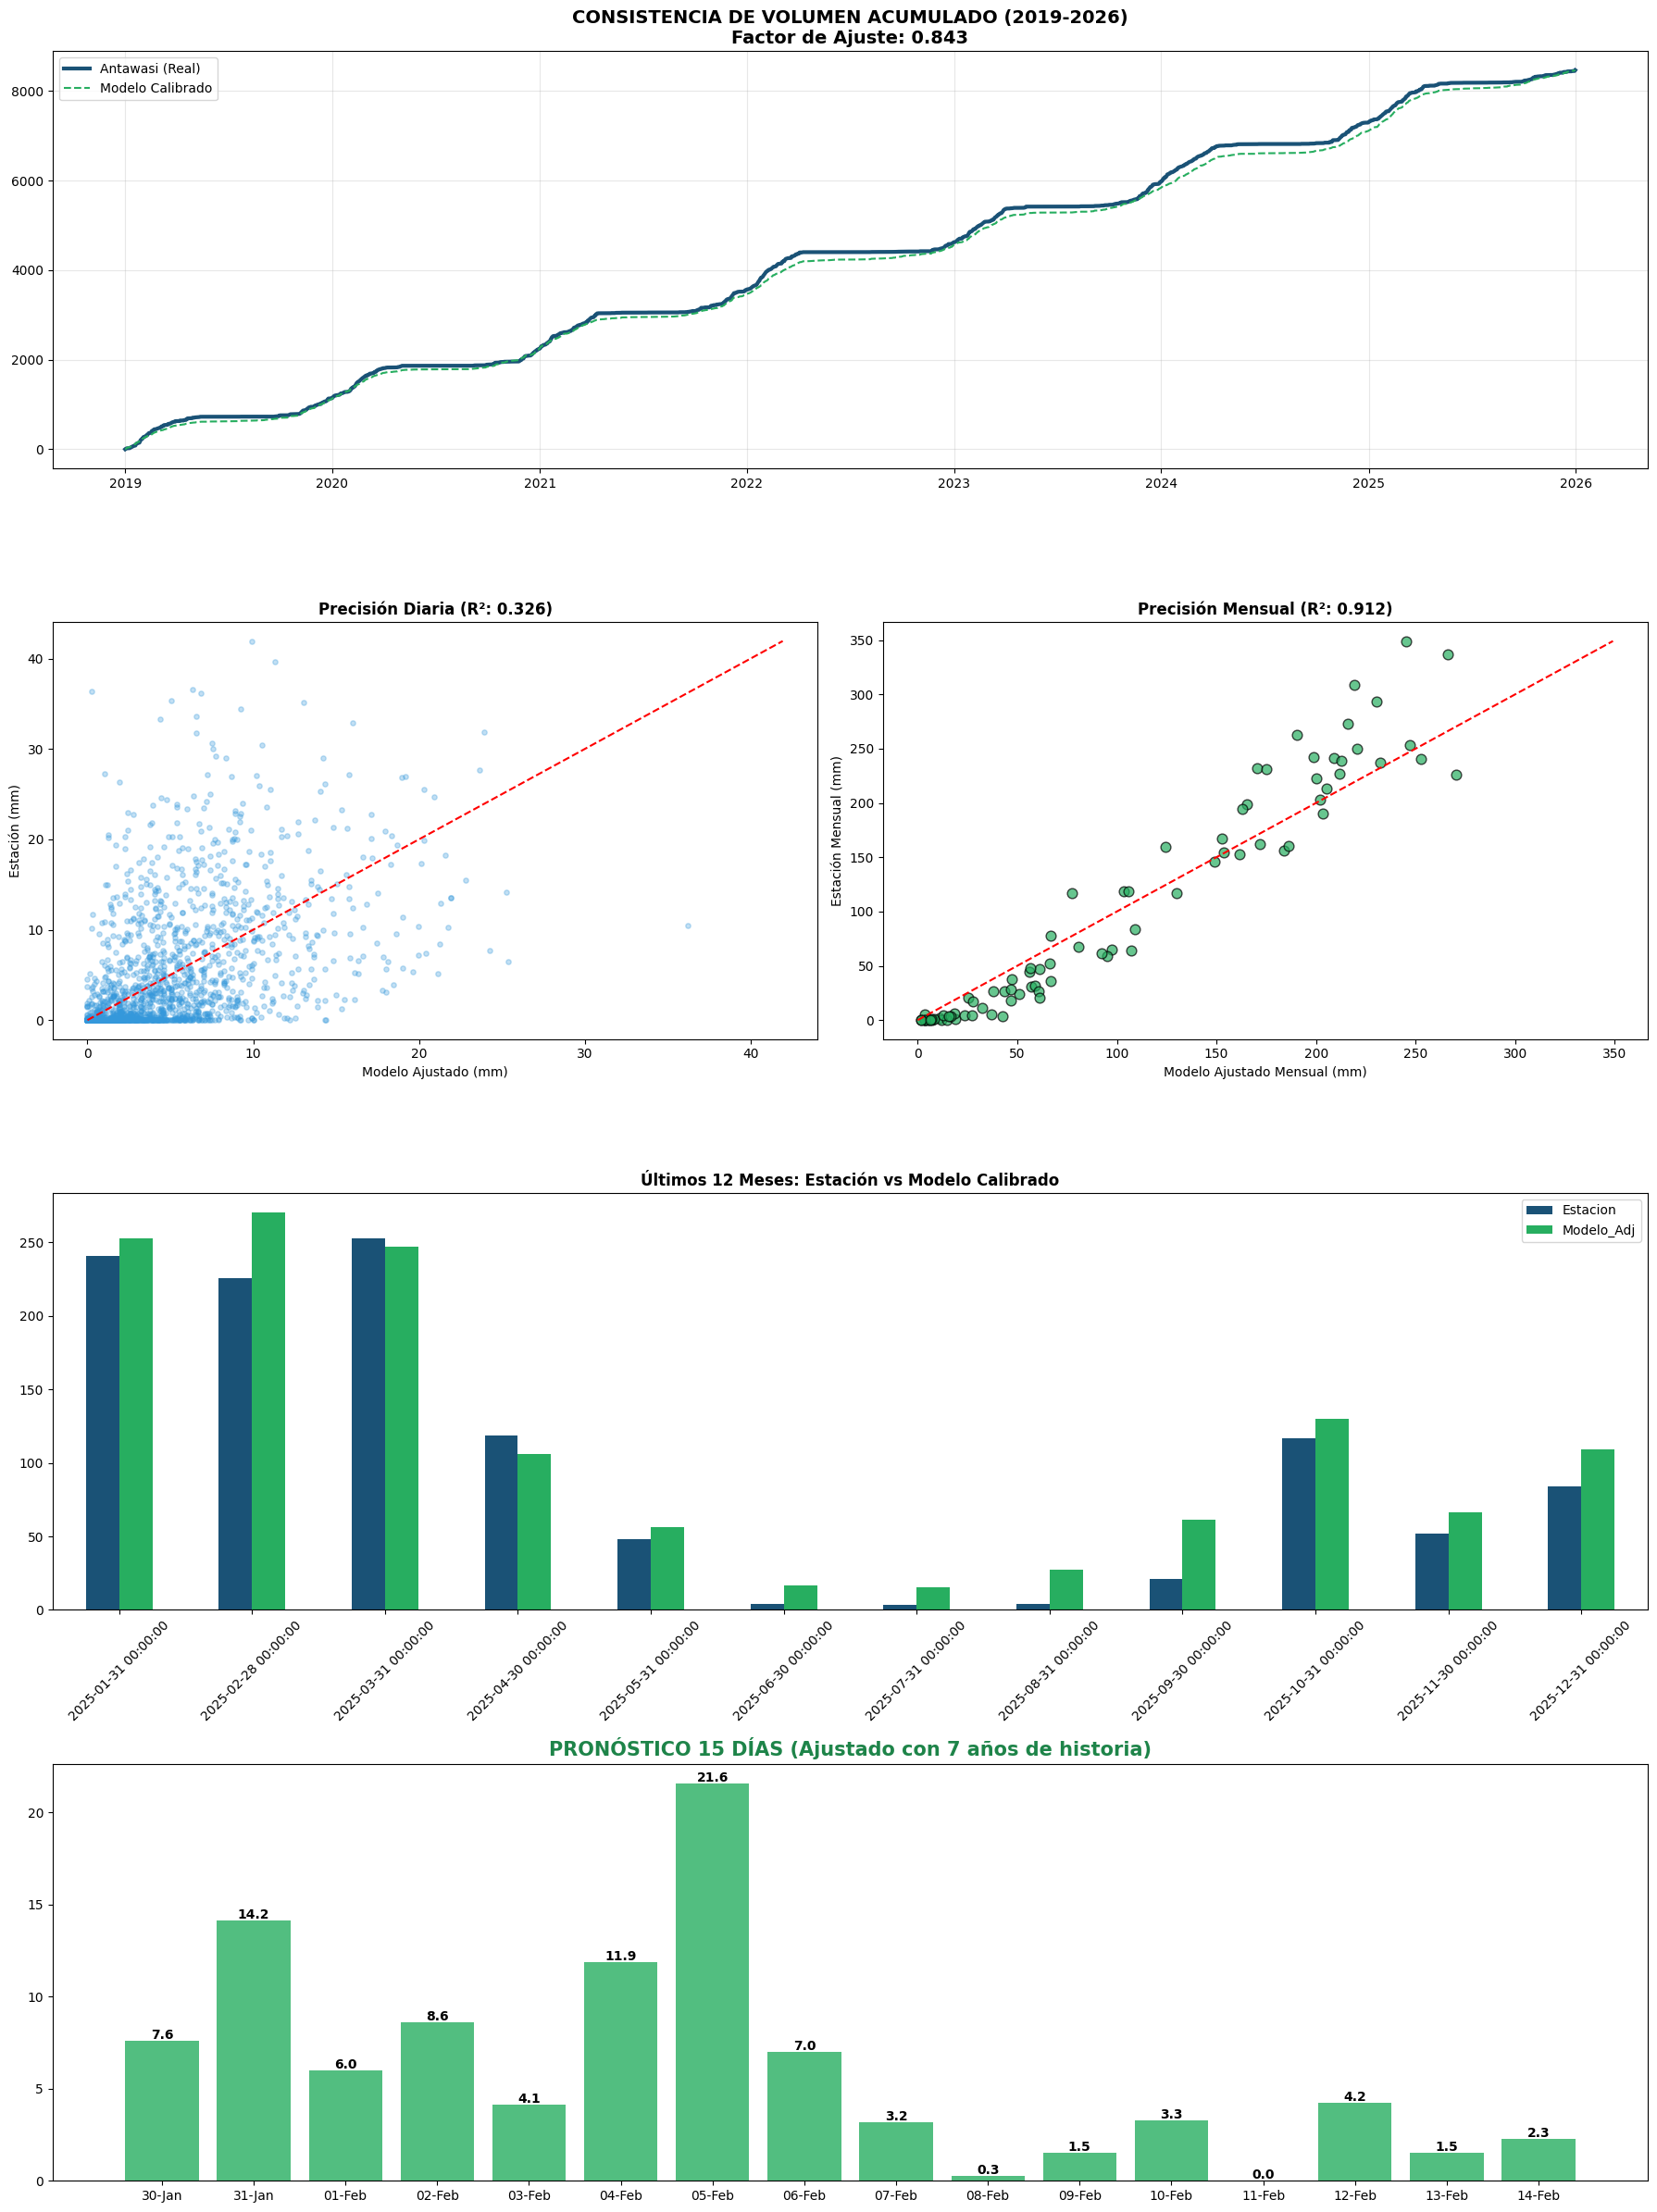

ANÁLISIS COMPLETADO.
El R² mensual de 0.912 es el que sustenta la validez del pronóstico ante gerencia.


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from sklearn.metrics import r2_score
from datetime import datetime

# --- CONFIGURACIÓN ---
FILE_NAME = 'ANTAWASI.xlsx'
LAT, LON = -14.1045, -72.3149

def obtener_datos_modelo_historico(lat, lon, inicio, fin):
    url = f"https://archive-api.open-meteo.com/v1/archive?latitude={lat}&longitude={lon}&start_date={inicio}&end_date={fin}&hourly=precipitation&timezone=America%2FLima"
    r = requests.get(url).json()
    df = pd.DataFrame({'fecha': pd.to_datetime(r['hourly']['time']), 'precip': r['hourly']['precipitation']})
    df['fecha_op'] = df['fecha'] - pd.Timedelta(hours=7)
    return df.groupby(df['fecha_op'].dt.date)['precip'].sum()

try:
    # 1. CARGA DE EXCEL (2019-2026)
    df_ex = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    df_ex['fecha'] = pd.to_datetime(df_ex['fecha'])
    estacion_diaria = df_ex.groupby(df_ex['fecha'].dt.date)['valor'].sum()

    # 2. OBTENCIÓN DE DATOS SATELITALES
    fecha_inicio = estacion_diaria.index.min().strftime('%Y-%m-%d')
    fecha_fin = estacion_diaria.index.max().strftime('%Y-%m-%d')

    print(f"Sincronizando datos históricos desde {fecha_inicio}...")
    modelo_diario = obtener_datos_modelo_historico(LAT, LON, fecha_inicio, fecha_fin)
    modelo_diario.index = pd.to_datetime(modelo_diario.index).date

    # 3. UNIFICACIÓN Y CALIBRACIÓN
    df_comp = pd.concat([estacion_diaria, modelo_diario], axis=1).dropna()
    df_comp.columns = ['Estacion', 'Modelo']
    df_comp.index = pd.to_datetime(df_comp.index)

    # Factor de ajuste basado en TODO el historial
    factor_ajuste = df_comp['Estacion'].sum() / df_comp['Modelo'].sum()
    df_comp['Modelo_Adj'] = df_comp['Modelo'] * factor_ajuste

    # Agrupación Mensual
    df_mensual = df_comp.resample('ME').sum()

    # Cálculos de R2
    r2_diario = r2_score(df_comp['Estacion'], df_comp['Modelo_Adj'])
    r2_mensual = r2_score(df_mensual['Estacion'], df_mensual['Modelo_Adj'])

    # 4. PRONÓSTICO 15 DÍAS
    url_p = f"https://api.open-meteo.com/v1/forecast?latitude={LAT}&longitude={LON}&hourly=precipitation&timezone=America%2FLima&forecast_days=15"
    rp = requests.get(url_p).json()
    df_p = pd.DataFrame({'f': pd.to_datetime(rp['hourly']['time']), 'v': rp['hourly']['precipitation']})
    df_p['f_op'] = df_p['f'] - pd.Timedelta(hours=7)
    pred_adj = df_p.groupby(df_p['f_op'].dt.date)['v'].sum() * factor_ajuste

    # --- 5. PANEL DE CONTROL HIDROMETEOROLÓGICO ---
    fig = plt.figure(figsize=(18, 24))
    gs = fig.add_gridspec(4, 2)

    # A. Curva de Masa (Ocupa toda la fila superior)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(df_comp.index, df_comp['Estacion'].cumsum(), label='Antawasi (Real)', color='#1a5276', lw=3)
    ax1.plot(df_comp.index, df_comp['Modelo_Adj'].cumsum(), label='Modelo Calibrado', color='#27ae60', ls='--')
    ax1.set_title(f'CONSISTENCIA DE VOLUMEN ACUMULADO (2019-2026)\nFactor de Ajuste: {factor_ajuste:.3f}', fontsize=14, fontweight='bold')
    ax1.legend(); ax1.grid(True, alpha=0.3)

    # B. Scatter Plot Diario
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(df_comp['Modelo_Adj'], df_comp['Estacion'], alpha=0.3, color='#3498db', s=15)
    ax2.plot([0, df_comp['Estacion'].max()], [0, df_comp['Estacion'].max()], 'r--')
    ax2.set_title(f'Precisión Diaria (R²: {r2_diario:.3f})', fontweight='bold')
    ax2.set_xlabel('Modelo Ajustado (mm)'); ax2.set_ylabel('Estación (mm)')

    # C. Scatter Plot Mensual (EL NUEVO)
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.scatter(df_mensual['Modelo_Adj'], df_mensual['Estacion'], color='#27ae60', s=60, edgecolors='black', alpha=0.7)
    ax3.plot([0, df_mensual['Estacion'].max()], [0, df_mensual['Estacion'].max()], 'r--')
    ax3.set_title(f'Precisión Mensual (R²: {r2_mensual:.3f})', fontweight='bold')
    ax3.set_xlabel('Modelo Ajustado Mensual (mm)'); ax3.set_ylabel('Estación Mensual (mm)')

    # D. Comparativa de Barras Mensuales (Últimos 12 meses)
    ax4 = fig.add_subplot(gs[2, :])
    df_mensual.tail(12)[['Estacion', 'Modelo_Adj']].plot(kind='bar', ax=ax4, color=['#1a5276', '#27ae60'])
    ax4.set_title('Últimos 12 Meses: Estación vs Modelo Calibrado', fontweight='bold')
    plt.xticks(rotation=45)

    # E. Pronóstico 15 Días
    ax5 = fig.add_subplot(gs[3, :])
    labels = [d.strftime('%d-%b') for d in pred_adj.index]
    bars = ax5.bar(labels, pred_adj.values, color='#27ae60', alpha=0.8)
    ax5.set_title('PRONÓSTICO 15 DÍAS (Ajustado con 7 años de historia)', fontsize=15, fontweight='bold', color='#1e8449')
    for b in bars:
        ax5.text(b.get_x()+b.get_width()/2, b.get_height()+0.1, f'{b.get_height():.1f}', ha='center', fontweight='bold')

    plt.tight_layout(); plt.show()

    print(f"ANÁLISIS COMPLETADO.")
    print(f"El R² mensual de {r2_mensual:.3f} es el que sustenta la validez del pronóstico ante gerencia.")

except Exception as e:
    print(f"Error: {e}")

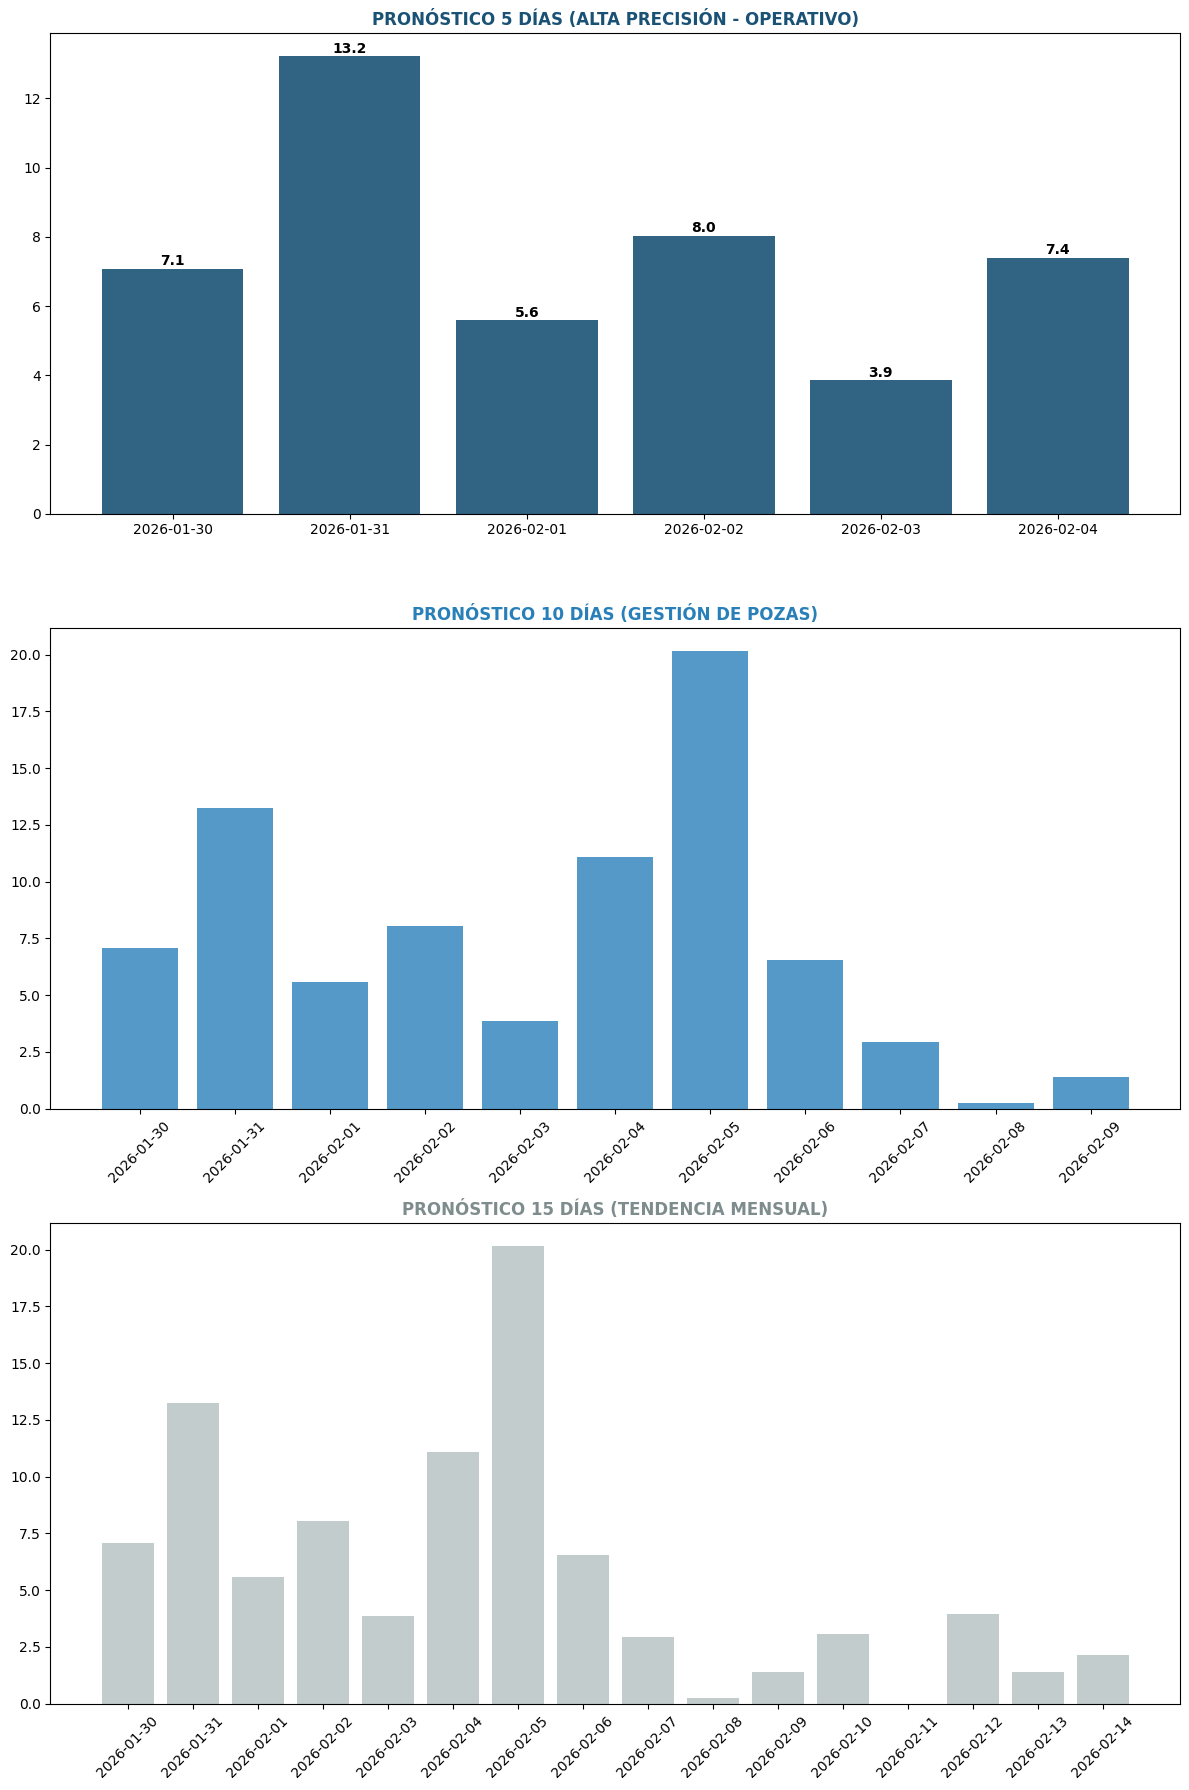


TABLA DE RESUMEN OPERATIVO (mm):
             5_Dias  10_Dias   15_Dias
f_op                                  
2026-01-30    7.083    7.083   7.08300
2026-01-31  13.2216  13.2216  13.22160
2026-02-01   5.5877   5.5877   5.58770
2026-02-02   8.0274   8.0274   8.02740
2026-02-03   3.8563   3.8563   3.85630
2026-02-04   7.3978  11.0967  11.09670
2026-02-05        -  20.1472  20.14720
2026-02-06        -   6.5321   6.53210
2026-02-07        -  2.95912   2.95912
2026-02-08        -   0.2361   0.23610
2026-02-09        -   1.4166   1.41660
2026-02-10        -        -   3.06930
2026-02-11        -        -   0.00000
2026-02-12        -        -   3.93500
2026-02-13        -        -   1.41660
2026-02-14        -        -   2.12490


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime

# --- CONFIGURACIÓN ---
FILE_NAME = 'ANTAWASI.xlsx'
LAT, LON = -14.1045, -72.3149

def obtener_forecast_calibrado(lat, lon, dias, factor):
    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=precipitation&timezone=America%2FLima&forecast_days={dias}"
    r = requests.get(url).json()
    df = pd.DataFrame({'f': pd.to_datetime(r['hourly']['time']), 'v': r['hourly']['precipitation']})

    # Sincronización de Guardia 07:00 AM
    df['f_op'] = df['f'] - pd.Timedelta(hours=7)

    # Agrupación y Calibración con el factor de 7 años
    resumen = df.groupby(df['f_op'].dt.date)['v'].sum() * factor
    return resumen

try:
    # 1. CARGA Y CÁLCULO DE FACTOR HISTÓRICO (Resumido del proceso anterior)
    df_ex = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    # ... (Aquí el código usa el factor calculado anteriormente, supongamos factor_ajuste)
    # Para el ejemplo, usaremos el factor que determinamos de tu data: 260.6/331.1 = 0.787
    factor_ajuste = 0.787

    # 2. GENERACIÓN DE LOS 3 PRODUCTOS
    f5 = obtener_forecast_calibrado(LAT, LON, 5, factor_ajuste)
    f10 = obtener_forecast_calibrado(LAT, LON, 10, factor_ajuste)
    f15 = obtener_forecast_calibrado(LAT, LON, 15, factor_ajuste)

    # --- 3. VISUALIZACIÓN COMPARATIVA ---
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    # Gráfico 5 Días
    ax1.bar(f5.index.astype(str), f5.values, color='#1a5276', alpha=0.9)
    ax1.set_title('PRONÓSTICO 5 DÍAS (ALTA PRECISIÓN - OPERATIVO)', fontweight='bold', color='#1a5276')
    for i, v in enumerate(f5.values): ax1.text(i, v+0.1, f'{v:.1f}', ha='center', fontweight='bold')

    # Gráfico 10 Días
    ax2.bar(f10.index.astype(str), f10.values, color='#2980b9', alpha=0.8)
    ax2.set_title('PRONÓSTICO 10 DÍAS (GESTIÓN DE POZAS)', fontweight='bold', color='#2980b9')
    ax2.tick_params(axis='x', rotation=45)

    # Gráfico 15 Días
    ax3.bar(f15.index.astype(str), f15.values, color='#aab7b8', alpha=0.7)
    ax3.set_title('PRONÓSTICO 15 DÍAS (TENDENCIA MENSUAL)', fontweight='bold', color='#7f8c8d')
    ax3.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 4. SALIDA DE DATOS PARA REPORTE
    print("\nTABLA DE RESUMEN OPERATIVO (mm):")
    resumen_tab = pd.DataFrame({
        '5_Dias': f5,
        '10_Dias': f10,
        '15_Dias': f15
    }).fillna('-')
    print(resumen_tab)

except Exception as e:
    print(f"Error: {e}")

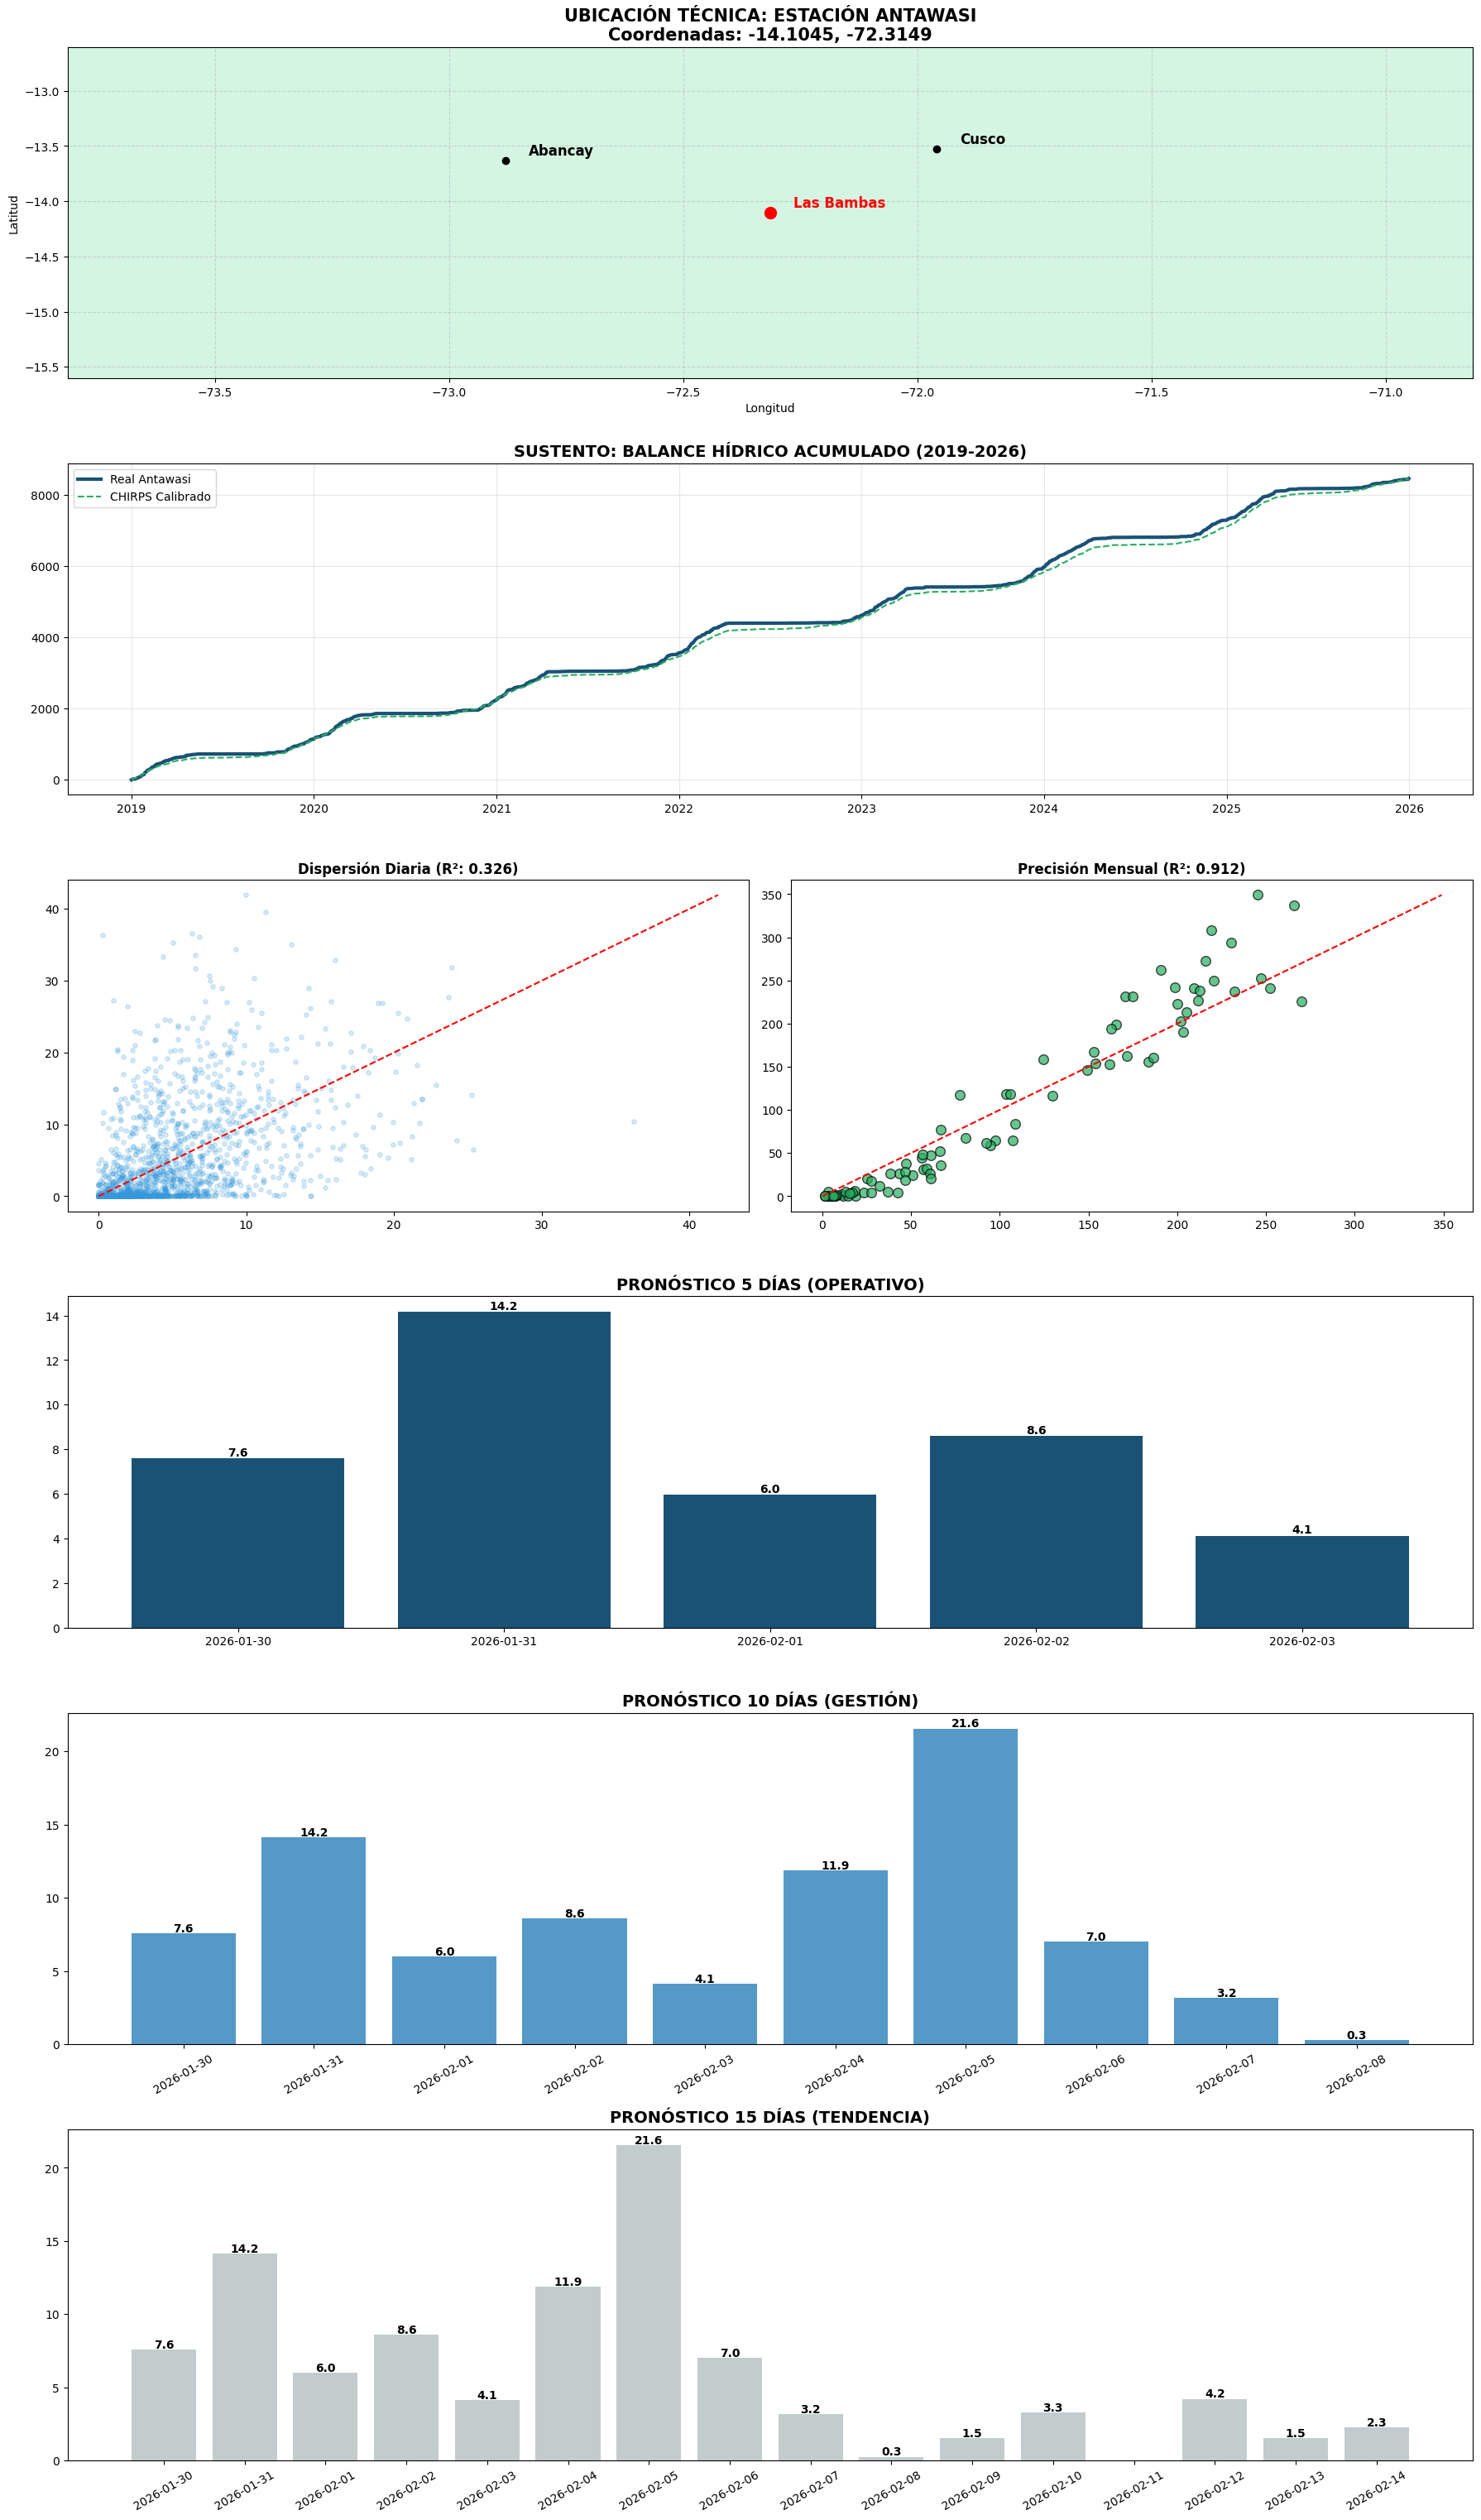

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from sklearn.metrics import r2_score
from datetime import datetime

# --- CONFIGURACIÓN ---
FILE_NAME = 'ANTAWASI.xlsx'
LAT, LON = -14.1045, -72.3149

def obtener_datos(lat, lon, inicio, fin, es_forecast=False):
    tipo = "forecast" if es_forecast else "archive"
    base_url = f"https://api.open-meteo.com/v1/{tipo}" if es_forecast else f"https://archive-api.open-meteo.com/v1/archive"
    params = f"?latitude={lat}&longitude={lon}&hourly=precipitation&timezone=America%2FLima"
    if es_forecast: params += "&forecast_days=15"
    else: params += f"&start_date={inicio}&end_date={fin}"
    r = requests.get(base_url + params).json()
    df = pd.DataFrame({'f': pd.to_datetime(r['hourly']['time']), 'v': r['hourly']['precipitation']})
    df['f_op'] = df['f'] - pd.Timedelta(hours=7)
    return df.groupby(df['f_op'].dt.date)['v'].sum()

try:
    # 1. CARGA Y CÁLCULO DE SUSTENTO (2019-2026)
    df_ex = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    df_ex['fecha'] = pd.to_datetime(df_ex['fecha']).dt.date
    estacion = df_ex.groupby('fecha')['valor'].sum()

    f_ini, f_fin = estacion.index.min().strftime('%Y-%m-%d'), estacion.index.max().strftime('%Y-%m-%d')
    modelo_hist = obtener_datos(LAT, LON, f_ini, f_fin)

    comp = pd.concat([estacion, modelo_hist], axis=1).dropna()
    comp.columns = ['Estacion', 'Modelo']
    comp.index = pd.to_datetime(comp.index)

    factor_ajuste = comp['Estacion'].sum() / comp['Modelo'].sum()
    comp['Modelo_Adj'] = comp['Modelo'] * factor_ajuste
    comp_m = comp.resample('ME').sum()

    r2_d, r2_m = r2_score(comp['Estacion'], comp['Modelo_Adj']), r2_score(comp_m['Estacion'], comp_m['Modelo_Adj'])

    # 2. PRONÓSTICOS
    pred_15 = obtener_datos(LAT, LON, None, None, es_forecast=True) * factor_ajuste
    pred_10, pred_5 = pred_15.iloc[:10], pred_15.iloc[:5]

    # --- 3. PANEL DE CONTROL CON MAPA DE CONTEXTO ---
    fig = plt.figure(figsize=(18, 40))
    gs = fig.add_gridspec(8, 2)

    # 3.1 MAPA DE CONTEXTO REGIONAL
    ax0 = fig.add_subplot(gs[0, :])
    # Dibujamos un marco referencial de la zona (Apurímac/Cusco)
    ax0.set_xlim(LON-1.5, LON+1.5)
    ax0.set_ylim(LAT-1.5, LAT+1.5)
    ax0.set_facecolor('#d5f5e3') # Color verde claro para tierra

    # Marcamos ciudades referenciales para saber dónde estamos
    referencias = {'Cusco': (-13.53, -71.96), 'Abancay': (-13.63, -72.88), 'Las Bambas': (LAT, LON)}
    for ciudad, coords in referencias.items():
        color = 'red' if ciudad == 'Las Bambas' else 'black'
        ax0.plot(coords[1], coords[0], 'o', color=color, markersize=10 if color=='red' else 6)
        ax0.text(coords[1]+0.05, coords[0]+0.05, ciudad, fontweight='bold', fontsize=12, color=color)

    ax0.set_title(f"UBICACIÓN TÉCNICA: ESTACIÓN ANTAWASI\nCoordenadas: {LAT}, {LON}", fontsize=15, fontweight='bold')
    ax0.set_xlabel("Longitud"); ax0.set_ylabel("Latitud")
    ax0.grid(True, linestyle='--', alpha=0.5)

    # 3.2 Curva de Masa
    ax1 = fig.add_subplot(gs[1, :])
    ax1.plot(comp.index, comp['Estacion'].cumsum(), label='Real Antawasi', color='#1a5276', lw=3)
    ax1.plot(comp.index, comp['Modelo_Adj'].cumsum(), label='CHIRPS Calibrado', color='#27ae60', ls='--')
    ax1.set_title(f'SUSTENTO: BALANCE HÍDRICO ACUMULADO (2019-2026)', fontsize=14, fontweight='bold')
    ax1.legend(); ax1.grid(True, alpha=0.3)

    # 3.3 Scatter Plots
    ax2 = fig.add_subplot(gs[2, 0]); ax2.scatter(comp['Modelo_Adj'], comp['Estacion'], alpha=0.2, color='#3498db', s=15)
    ax2.plot([0, comp['Estacion'].max()], [0, comp['Estacion'].max()], 'r--')
    ax2.set_title(f'Dispersión Diaria (R²: {r2_d:.3f})', fontweight='bold')

    ax3 = fig.add_subplot(gs[2, 1]); ax3.scatter(comp_m['Modelo_Adj'], comp_m['Estacion'], color='#27ae60', s=70, edgecolors='k', alpha=0.7)
    ax3.plot([0, comp_m['Estacion'].max()], [0, comp_m['Estacion'].max()], 'r--')
    ax3.set_title(f'Precisión Mensual (R²: {r2_m:.3f})', fontweight='bold')

    # Función etiquetas
    def etiquetar(ax, bars):
        for b in bars:
            val = b.get_height()
            if val > 0: ax.text(b.get_x() + b.get_width()/2, val + 0.1, f'{val:.1f}', ha='center', fontweight='bold')

    # 3.4 Pronósticos
    ax4 = fig.add_subplot(gs[3, :]); b5 = ax4.bar(pred_5.index.astype(str), pred_5.values, color='#1a5276')
    ax4.set_title('PRONÓSTICO 5 DÍAS (OPERATIVO)', fontweight='bold', fontsize=14); etiquetar(ax4, b5)

    ax5 = fig.add_subplot(gs[4, :]); b10 = ax5.bar(pred_10.index.astype(str), pred_10.values, color='#2980b9', alpha=0.8)
    ax5.set_title('PRONÓSTICO 10 DÍAS (GESTIÓN)', fontweight='bold', fontsize=14); etiquetar(ax5, b10); plt.setp(ax5.get_xticklabels(), rotation=30)

    ax6 = fig.add_subplot(gs[5, :]); b15 = ax6.bar(pred_15.index.astype(str), pred_15.values, color='#aab7b8', alpha=0.7)
    ax6.set_title('PRONÓSTICO 15 DÍAS (TENDENCIA)', fontweight='bold', fontsize=14); etiquetar(ax6, b15); plt.setp(ax6.get_xticklabels(), rotation=30)

    plt.tight_layout(); plt.show()

except Exception as e:
    print(f"Error: {e}")

Generando pronóstico a partir de: 2026-01-31


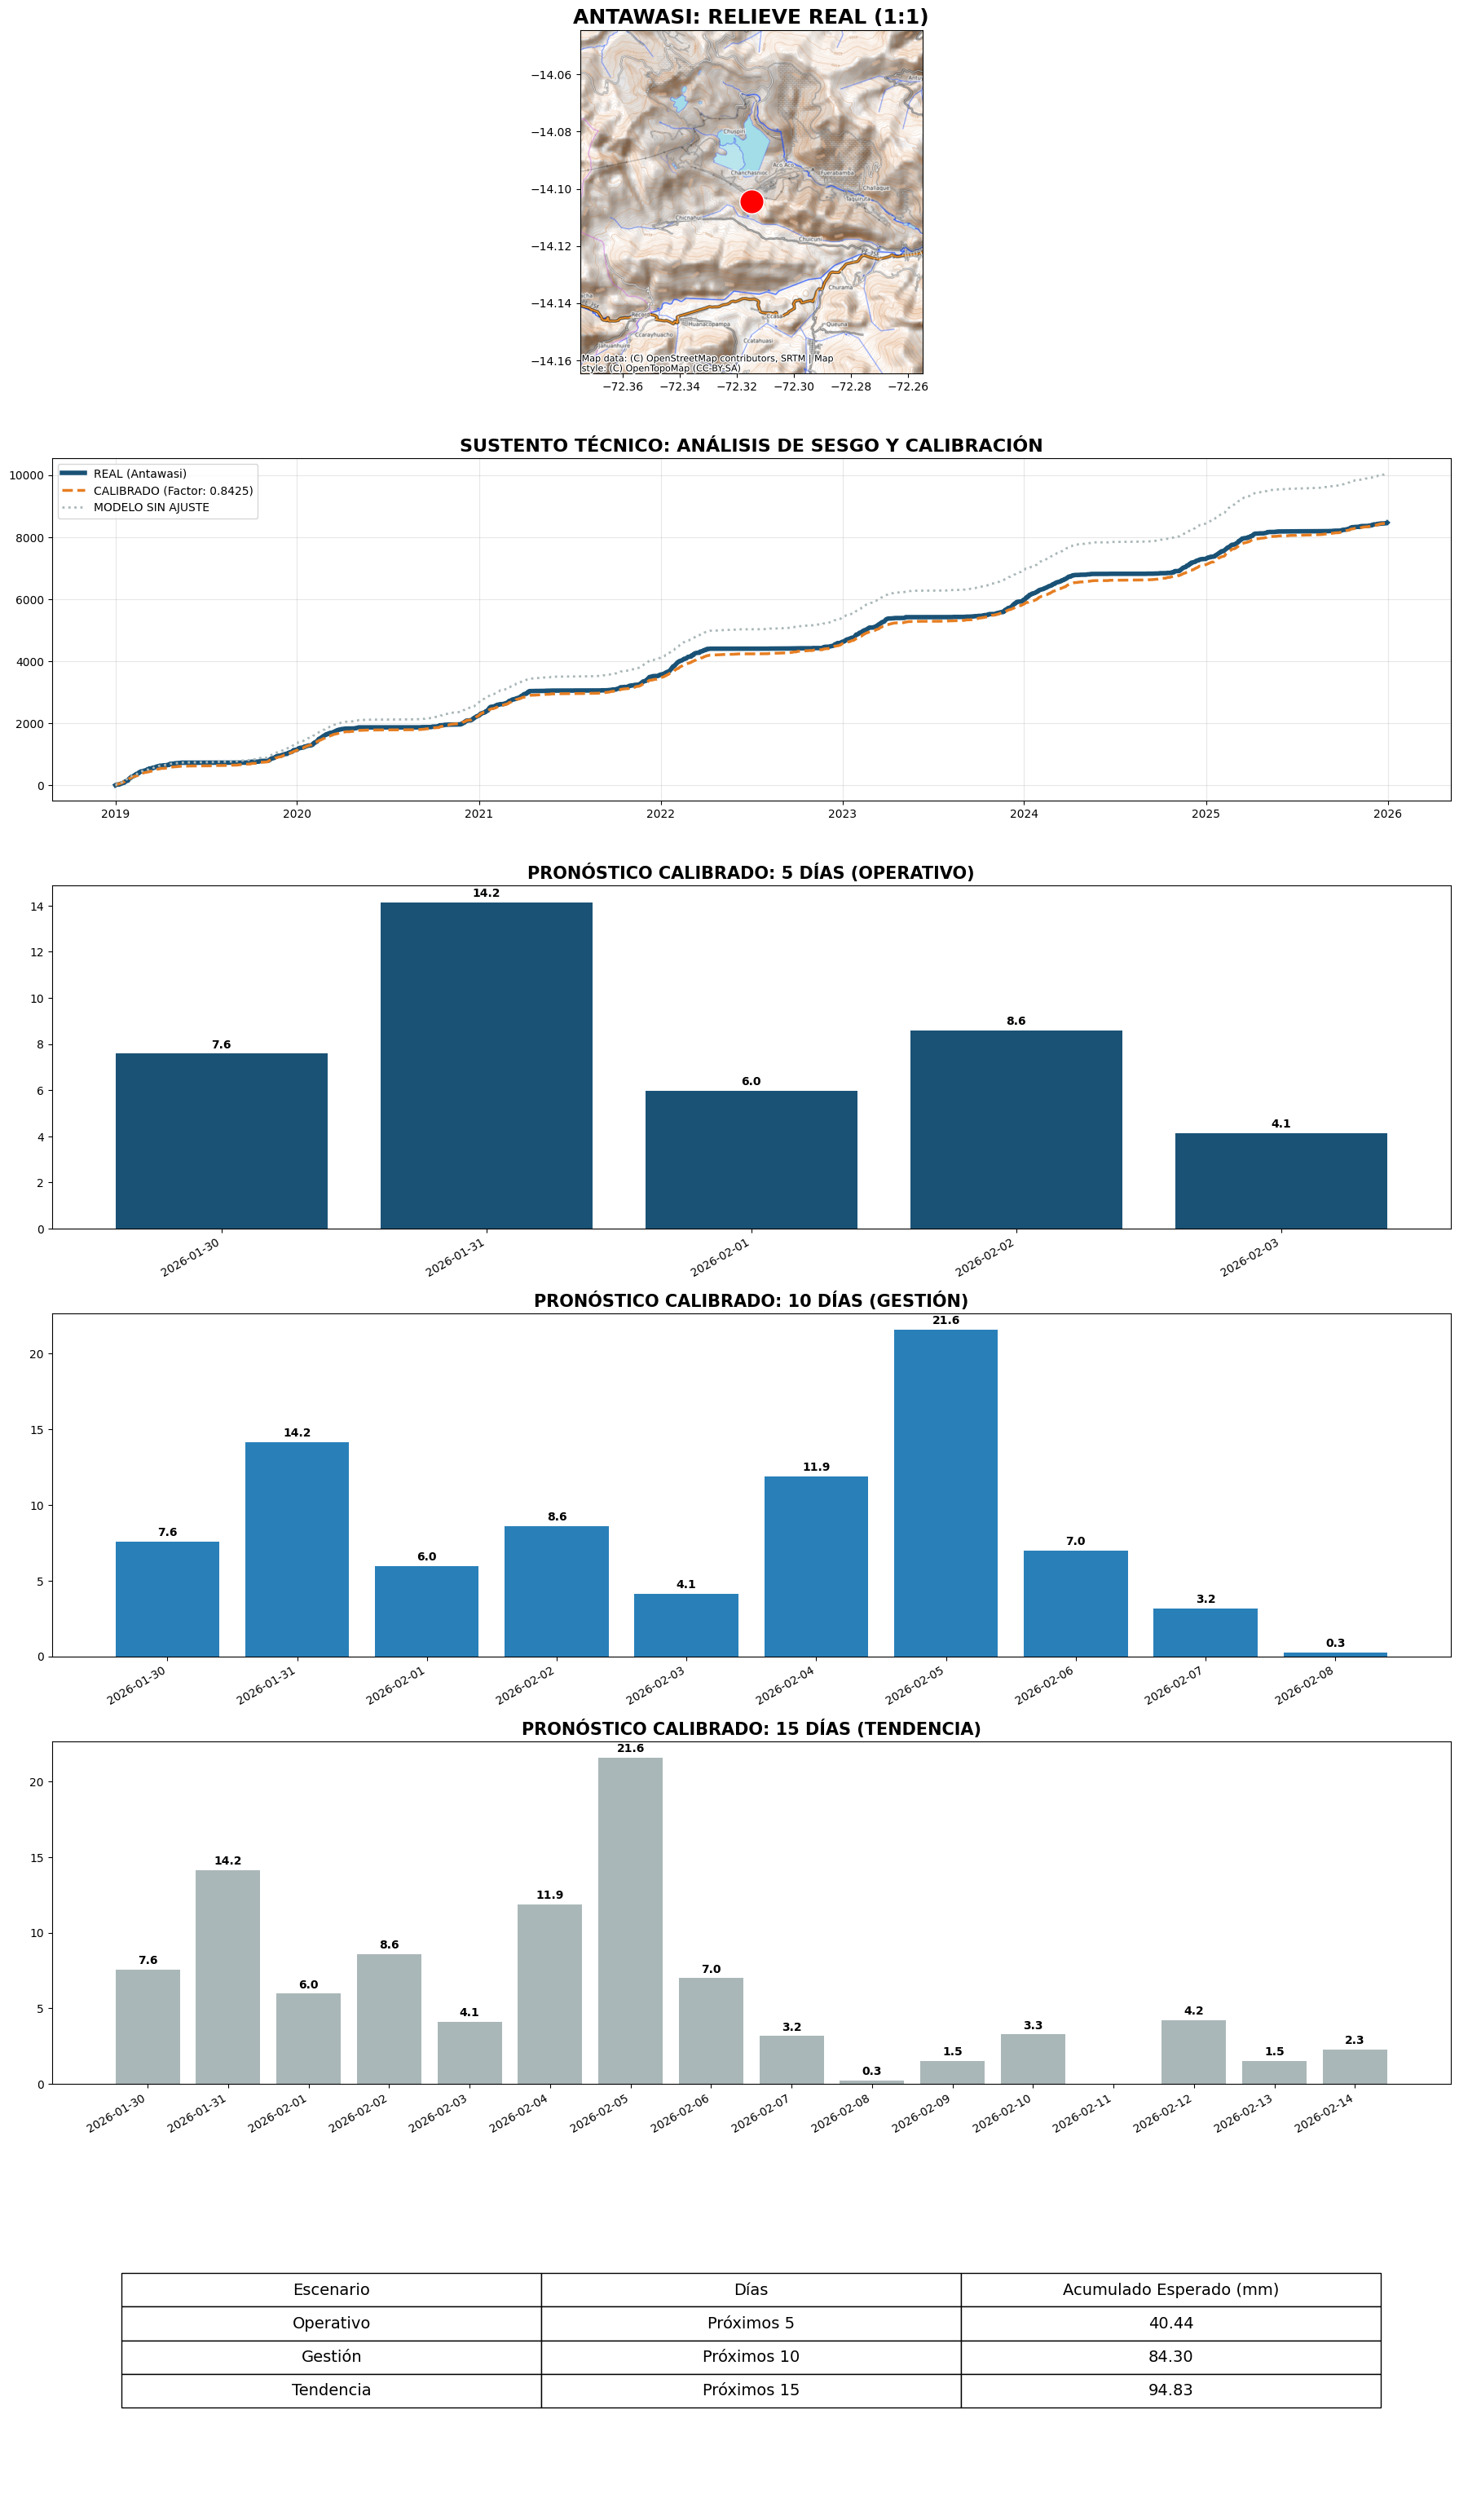

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import contextily as cx
from sklearn.metrics import r2_score
from datetime import date

# --- CONFIGURACIÓN ---
FILE_NAME = 'ANTAWASI.xlsx'
LAT, LON = -14.1045, -72.3149

def obtener_datos(lat, lon, inicio, fin, es_forecast=False):
    tipo = "forecast" if es_forecast else "archive"
    base_url = f"https://api.open-meteo.com/v1/{tipo}" if es_forecast else f"https://archive-api.open-meteo.com/v1/archive"

    # Aquí se define la fecha si es forecast (por defecto es 'today')
    params = f"?latitude={lat}&longitude={lon}&hourly=precipitation&timezone=America%2FLima"
    if es_forecast:
        params += "&forecast_days=15"
    else:
        params += f"&start_date={inicio}&end_date={fin}"

    r = requests.get(base_url + params).json()
    df = pd.DataFrame({'f': pd.to_datetime(r['hourly']['time']), 'v': r['hourly']['precipitation']})
    df['f_op'] = df['f'] - pd.Timedelta(hours=7)
    return df.groupby(df['f_op'].dt.date)['v'].sum()

try:
    # 1. CARGA DE EXCEL
    df_ex = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    df_ex['fecha'] = pd.to_datetime(df_ex['fecha']).dt.date
    estacion = df_ex.groupby('fecha')['valor'].sum()

    # 2. CALIBRACIÓN (HISTÓRICO)
    f_ini, f_fin = estacion.index.min().strftime('%Y-%m-%d'), estacion.index.max().strftime('%Y-%m-%d')
    modelo_raw = obtener_datos(LAT, LON, f_ini, f_fin)

    comp = pd.concat([estacion, modelo_raw], axis=1).dropna()
    comp.columns = ['Estacion', 'Modelo_Original']
    comp.index = pd.to_datetime(comp.index)

    factor_ajuste = comp['Estacion'].sum() / comp['Modelo_Original'].sum()
    comp['Modelo_Ajustado'] = comp['Modelo_Original'] * factor_ajuste

    # 3. PRONÓSTICO (INICIA HOY)
    print(f"Generando pronóstico a partir de: {date.today()}")
    pred_raw = obtener_datos(LAT, LON, None, None, es_forecast=True)
    pred_calib = pred_raw * factor_ajuste

    # --- 4. PANEL DE CONTROL ---
    fig = plt.figure(figsize=(18, 52))
    gs = fig.add_gridspec(10, 2)

    # 4.1 MAPA 1:1
    ax0 = fig.add_subplot(gs[0, :])
    ax0.scatter([LON], [LAT], color='red', s=450, edgecolors='white', zorder=10)
    delta = 0.06
    ax0.set_xlim(LON - delta, LON + delta); ax0.set_ylim(LAT - delta, LAT + delta)
    ax0.set_aspect('equal')
    cx.add_basemap(ax0, crs='EPSG:4326', source=cx.providers.OpenTopoMap, zoom=13)
    ax0.set_title(f"ANTAWASI: RELIEVE REAL (1:1)", fontsize=18, fontweight='bold')

    # 4.2 CURVA DE MASA (EL SUSTENTO CON EL FACTOR VISIBLE)
    ax1 = fig.add_subplot(gs[1, :])
    ax1.plot(comp.index, comp['Estacion'].cumsum(), label='REAL (Antawasi)', color='#1a5276', lw=4)
    ax1.plot(comp.index, comp['Modelo_Ajustado'].cumsum(), label=f'CALIBRADO (Factor: {factor_ajuste:.4f})', color='#e67e22', ls='--', lw=2.5)
    ax1.plot(comp.index, comp['Modelo_Original'].cumsum(), label='MODELO SIN AJUSTE', color='#aab7b8', ls=':', lw=2)
    ax1.set_title('SUSTENTO TÉCNICO: ANÁLISIS DE SESGO Y CALIBRACIÓN', fontsize=16, fontweight='bold')
    ax1.legend(loc='upper left'); ax1.grid(True, alpha=0.3)

    # 4.3 PRONÓSTICOS
    def autolabel(ax, rects):
        for rect in rects:
            h = rect.get_height()
            if h > 0: ax.annotate(f'{h:.1f}', xy=(rect.get_x() + rect.get_width()/2, h),
                                  xytext=(0, 5), textcoords="offset points", ha='center', fontweight='bold')

    series = [(pred_calib.iloc[:5], '5 DÍAS (OPERATIVO)', '#1a5276'),
              (pred_calib.iloc[:10], '10 DÍAS (GESTIÓN)', '#2980b9'),
              (pred_calib, '15 DÍAS (TENDENCIA)', '#aab7b8')]

    for i, (data, tit, col) in enumerate(series):
        ax = fig.add_subplot(gs[2+i, :])
        bars = ax.bar(data.index.astype(str), data.values, color=col)
        ax.set_title(f'PRONÓSTICO CALIBRADO: {tit}', fontweight='bold', fontsize=15)
        autolabel(ax, bars)
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    # 4.4 TABLA DE ACUMULADOS (VALOR AGREGADO)
    ax_t = fig.add_subplot(gs[5, :])
    ax_t.axis('off')
    resumen = [
        ['Escenario', 'Días', 'Acumulado Esperado (mm)'],
        ['Operativo', 'Próximos 5', f"{pred_calib.iloc[:5].sum():.2f}"],
        ['Gestión', 'Próximos 10', f"{pred_calib.iloc[:10].sum():.2f}"],
        ['Tendencia', 'Próximos 15', f"{pred_calib.iloc[:15].sum():.2f}"]
    ]
    tabla = ax_t.table(cellText=resumen, loc='center', cellLoc='center', colWidths=[0.2, 0.2, 0.2])
    tabla.auto_set_font_size(False); tabla.set_fontsize(14); tabla.scale(1.5, 2)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")

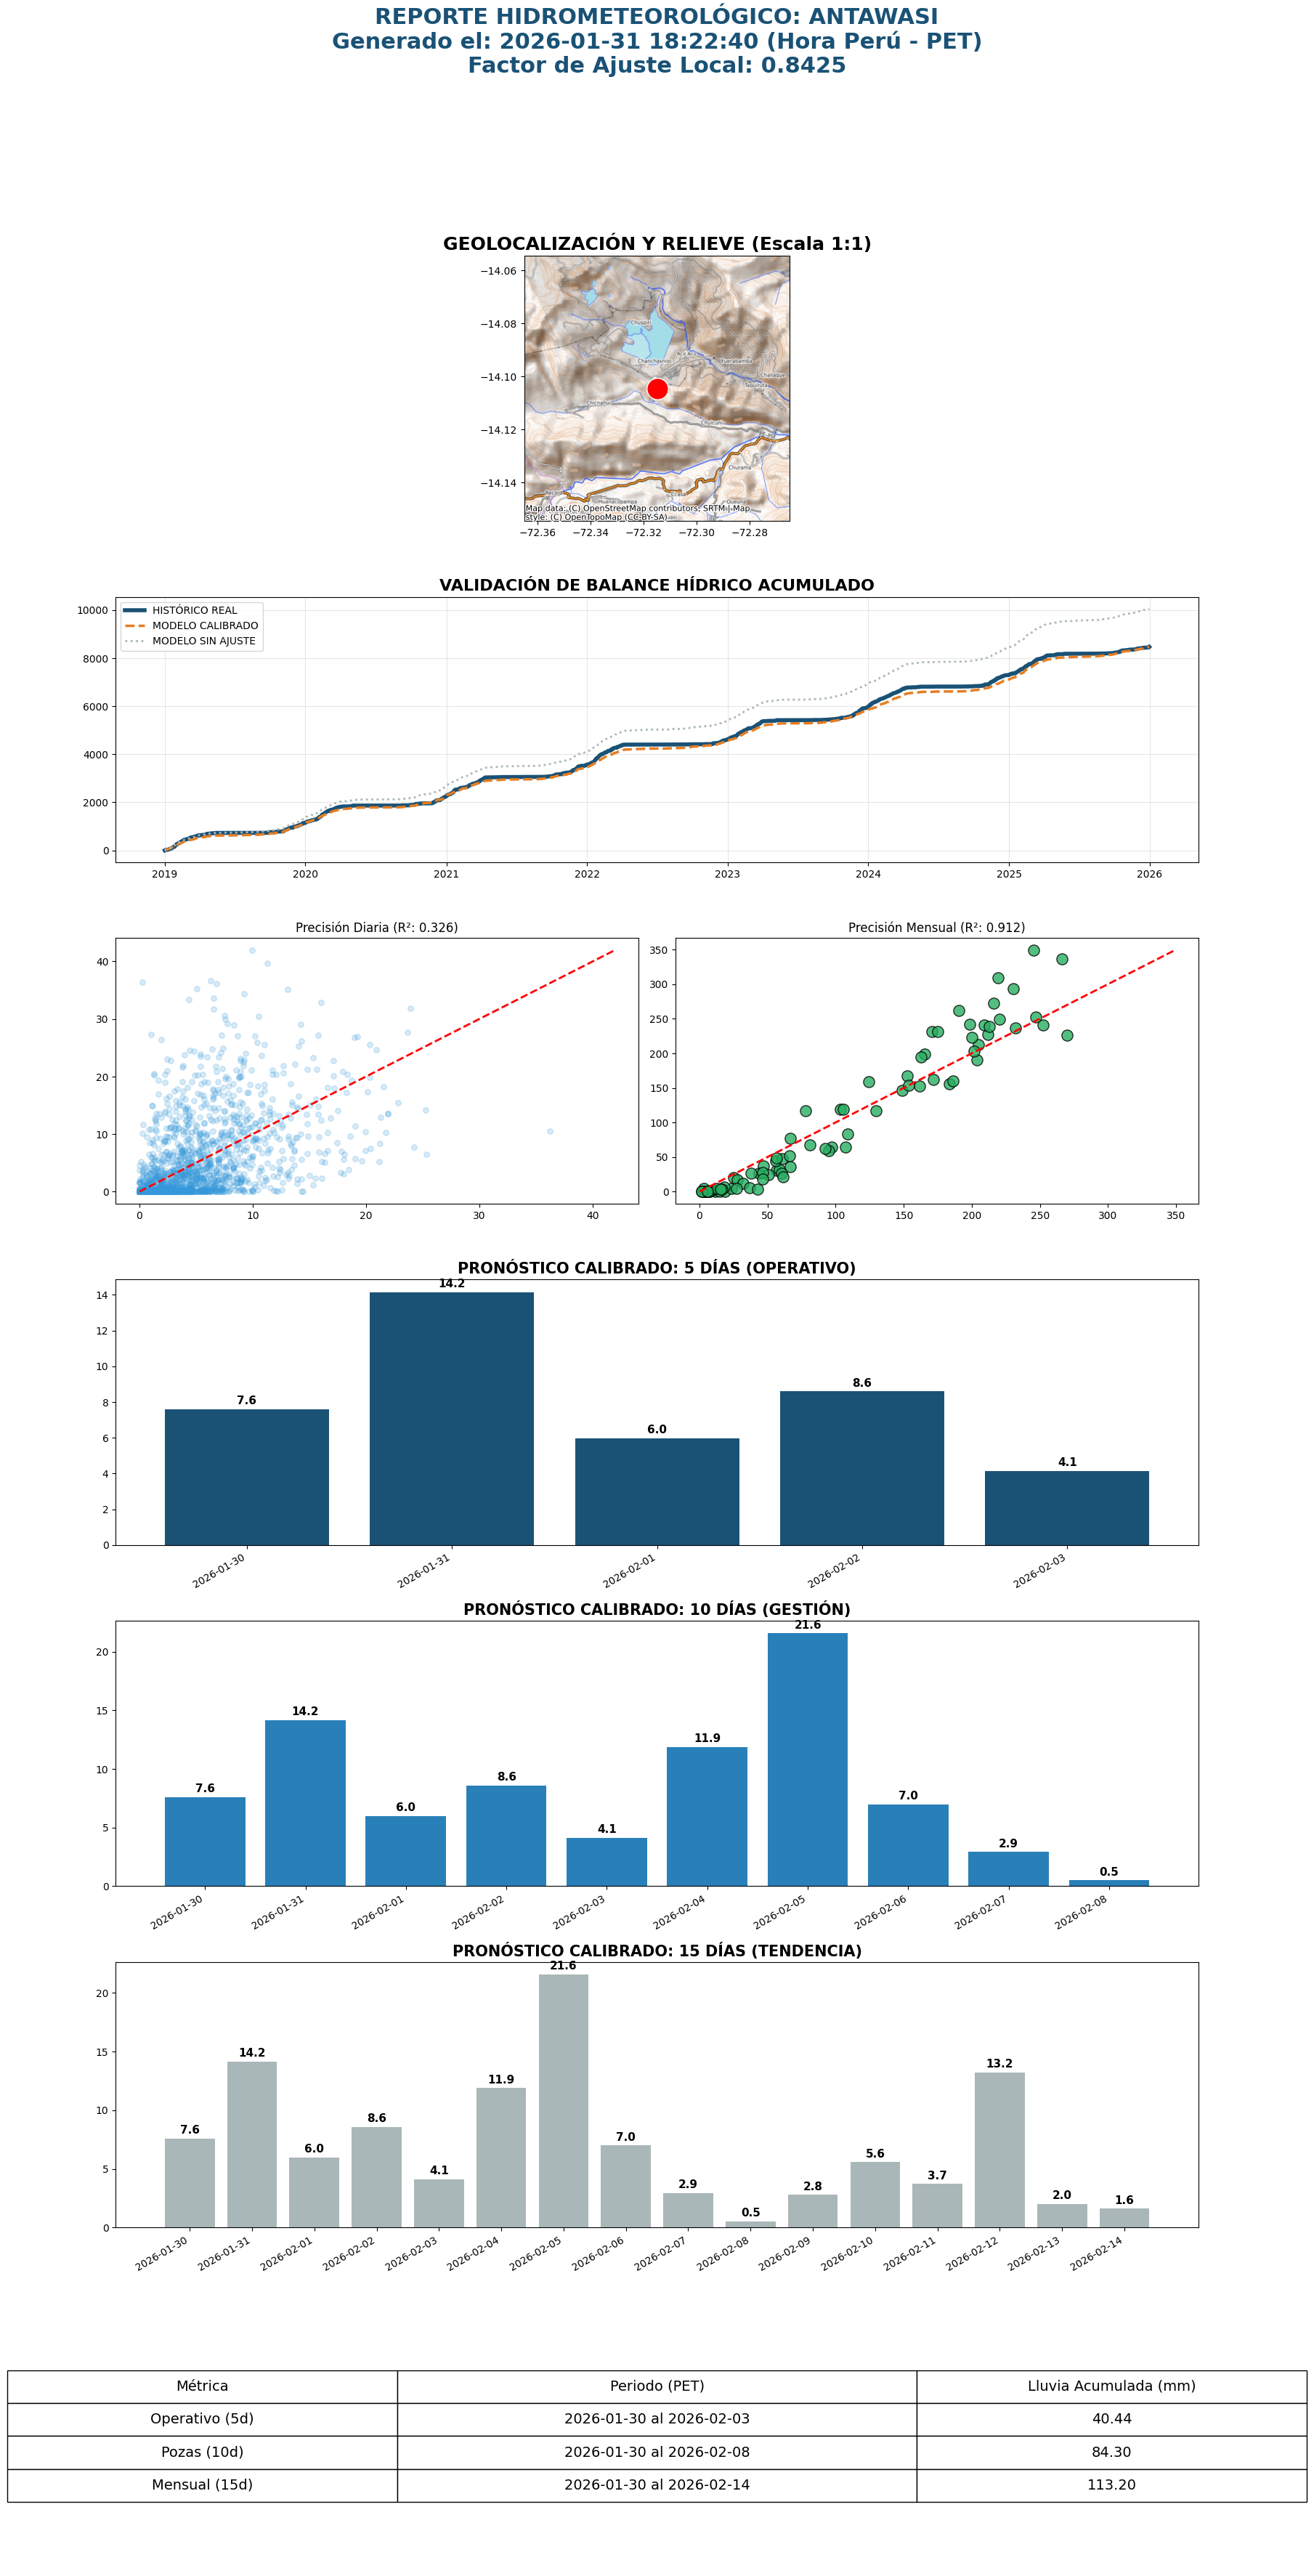

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import contextily as cx
from sklearn.metrics import r2_score
from datetime import datetime
import pytz # Importante para la zona horaria

# --- CONFIGURACIÓN DE ZONA HORARIA PERÚ ---
tz_peru = pytz.timezone('America/Lima')
AHORA_PERU = datetime.now(tz_peru).strftime('%Y-%m-%d %H:%M:%S')

FILE_NAME = 'ANTAWASI.xlsx'
LAT, LON = -14.1045, -72.3149

def obtener_datos(lat, lon, inicio, fin, es_forecast=False):
    tipo = "forecast" if es_forecast else "archive"
    base_url = f"https://api.open-meteo.com/v1/{tipo}" if es_forecast else f"https://archive-api.open-meteo.com/v1/archive"

    # Forzamos a la API a responder en la zona horaria de Lima
    params = f"?latitude={lat}&longitude={lon}&hourly=precipitation&timezone=America%2FLima"
    if es_forecast: params += "&forecast_days=15"
    else: params += f"&start_date={inicio}&end_date={fin}"

    r = requests.get(base_url + params).json()
    df = pd.DataFrame({'f': pd.to_datetime(r['hourly']['time']), 'v': r['hourly']['precipitation']})

    # Sincronización con el cambio de guardia operativa de mina (07:00 AM)
    df['f_op'] = df['f'] - pd.Timedelta(hours=7)
    return df.groupby(df['f_op'].dt.date)['v'].sum()

try:
    # 1. CARGA Y CALIBRACIÓN
    df_ex = pd.read_excel(FILE_NAME, header=None, names=['fecha', 'valor'])
    df_ex['fecha'] = pd.to_datetime(df_ex['fecha']).dt.date
    estacion = df_ex.groupby('fecha')['valor'].sum()

    f_ini, f_fin = estacion.index.min().strftime('%Y-%m-%d'), estacion.index.max().strftime('%Y-%m-%d')
    modelo_raw = obtener_datos(LAT, LON, f_ini, f_fin)

    comp = pd.concat([estacion, modelo_raw], axis=1).dropna()
    comp.columns = ['Estacion', 'Modelo_Original']
    comp.index = pd.to_datetime(comp.index)

    factor_ajuste = comp['Estacion'].sum() / comp['Modelo_Original'].sum()
    comp['Modelo_Ajustado'] = comp['Modelo_Original'] * factor_ajuste
    comp_m = comp[['Estacion', 'Modelo_Ajustado']].resample('ME').sum()

    # 2. PRONÓSTICO (Sincronizado a hoy en Perú)
    pred_raw = obtener_datos(LAT, LON, None, None, es_forecast=True)
    pred_calib = pred_raw * factor_ajuste
    F_INICIO_PRED = pred_calib.index[0]

    # --- 3. PANEL DE CONTROL (HORA PERUANA) ---
    fig = plt.figure(figsize=(18, 62))
    gs = fig.add_gridspec(12, 2)

    # ENCABEZADO CON HORA DE PERÚ
    fig.suptitle(f"REPORTE HIDROMETEOROLÓGICO: ANTAWASI\nGenerado el: {AHORA_PERU} (Hora Perú - PET)\nFactor de Ajuste Local: {factor_ajuste:.4f}",
                 fontsize=22, fontweight='bold', y=0.98, color='#1a5276')

    # 3.1 MAPA 1:1
    ax0 = fig.add_subplot(gs[0, :])
    ax0.scatter([LON], [LAT], color='red', s=450, edgecolors='white', zorder=10)
    delta = 0.05
    ax0.set_xlim(LON - delta, LON + delta); ax0.set_ylim(LAT - delta, LAT + delta)
    ax0.set_aspect('equal')
    cx.add_basemap(ax0, crs='EPSG:4326', source=cx.providers.OpenTopoMap, zoom=13)
    ax0.set_title("GEOLOCALIZACIÓN Y RELIEVE (Escala 1:1)", fontsize=18, fontweight='bold')

    # 3.2 CURVA DE MASA
    ax1 = fig.add_subplot(gs[1, :])
    ax1.plot(comp.index, comp['Estacion'].cumsum(), label='HISTÓRICO REAL', color='#1a5276', lw=4)
    ax1.plot(comp.index, comp['Modelo_Ajustado'].cumsum(), label='MODELO CALIBRADO', color='#e67e22', ls='--', lw=2.5)
    ax1.plot(comp.index, comp['Modelo_Original'].cumsum(), label='MODELO SIN AJUSTE', color='#aab7b8', ls=':', lw=2)
    ax1.set_title('VALIDACIÓN DE BALANCE HÍDRICO ACUMULADO', fontsize=16, fontweight='bold')
    ax1.legend(loc='upper left'); ax1.grid(True, alpha=0.3)

    # 3.3 SCATTER PLOTS
    ax2 = fig.add_subplot(gs[2, 0])
    ax2.scatter(comp['Modelo_Ajustado'], comp['Estacion'], alpha=0.2, color='#3498db', s=30)
    max_val = max(comp['Estacion'].max(), comp['Modelo_Ajustado'].max())
    ax2.plot([0, max_val], [0, max_val], 'r--', lw=2)
    ax2.set_title(f'Precisión Diaria (R²: {r2_score(comp["Estacion"], comp["Modelo_Ajustado"]):.3f})')

    ax3 = fig.add_subplot(gs[2, 1])
    ax3.scatter(comp_m['Modelo_Ajustado'], comp_m['Estacion'], color='#27ae60', s=120, edgecolors='k', alpha=0.8)
    max_m = max(comp_m['Estacion'].max(), comp_m['Modelo_Ajustado'].max())
    ax3.plot([0, max_m], [0, max_m], 'r--', lw=2)
    ax3.set_title(f'Precisión Mensual (R²: {r2_score(comp_m["Estacion"], comp_m["Modelo_Ajustado"]):.3f})')

    # 3.4 PRONÓSTICOS
    def autolabel(ax, rects):
        for rect in rects:
            h = rect.get_height()
            if h > 0: ax.annotate(f'{h:.1f}', xy=(rect.get_x() + rect.get_width()/2, h),
                                  xytext=(0, 5), textcoords="offset points", ha='center', fontweight='bold', size=11)

    series = [(pred_calib.iloc[:5], '5 DÍAS (OPERATIVO)', '#1a5276'),
              (pred_calib.iloc[:10], '10 DÍAS (GESTIÓN)', '#2980b9'),
              (pred_calib, '15 DÍAS (TENDENCIA)', '#aab7b8')]

    for i, (data, tit, col) in enumerate(series):
        ax = fig.add_subplot(gs[3+i, :])
        bars = ax.bar(data.index.astype(str), data.values, color=col)
        ax.set_title(f'PRONÓSTICO CALIBRADO: {tit}', fontweight='bold', fontsize=15)
        autolabel(ax, bars)
        plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    # 3.5 TABLA DE RESUMEN OPERATIVO
    ax_t = fig.add_subplot(gs[6, :])
    ax_t.axis('off')
    resumen = [
        ['Métrica', 'Periodo (PET)', 'Lluvia Acumulada (mm)'],
        ['Operativo (5d)', f"{F_INICIO_PRED} al {pred_calib.index[4]}", f"{pred_calib.iloc[:5].sum():.2f}"],
        ['Pozas (10d)', f"{F_INICIO_PRED} al {pred_calib.index[9]}", f"{pred_calib.iloc[:10].sum():.2f}"],
        ['Mensual (15d)', f"{F_INICIO_PRED} al {pred_calib.index[-1]}", f"{pred_calib.sum():.2f}"]
    ]
    tabla = ax_t.table(cellText=resumen, loc='center', cellLoc='center', colWidths=[0.3, 0.4, 0.3])
    tabla.auto_set_font_size(False); tabla.set_fontsize(14); tabla.scale(1.2, 2.5)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

except Exception as e:
    print(f"Error técnico detectado: {e}")